In [16]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
%matplotlib widget

import os
import tempfile

# torch random seed
torch.manual_seed(0)

# Lorenz PINN baseline
In this notebook we apply the same method as the DHO baseline to the Lorenz system. After some preliminary test, here we show what append if we limit the train time span between (0,0.25) training the short_lorenz_baseline. In a second part we will train the long_lorenz_baseline with the time span (0,1).

## Useful func

In [17]:
def lorenz(t, Y):
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    t (float): time
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return [dxdt, dydt, dzdt]


def seq_lorenz(Y):
    """
    This function returns the right-hand side of the Lorenz system of ordinary differential equations.
    Parameters:
    Y (array): state vector [x, y, z]

    Returns:
    array: [dxdt, dydt, dzdt]
    """

    x, y, z = Y[:, 0], Y[:, 1], Y[:, 2]
    dxdt = 10 * (y - x)
    dydt = x * (28 - z) - y
    dzdt = x * y - 8/3 * z

    return np.array([dxdt, dydt, dzdt]).T

In [18]:
def plot_components(X, Y):
    """
    This function plots the components of the state vector Y as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.grid()



def plot_compare_components(X, Y, Y_pred):
    """
    This function plots the components of the state vector Y and Y_pred as a function of time X.
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(X, Y[:,0], label='x')
    plt.plot(X, Y_pred[:,0], label='x_pred')
    plt.ylabel('x')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(X, Y[:,1], label='y')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.ylabel('y')
    plt.xlabel('time')
    plt.legend()
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(X, Y[:,2], label='z')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.ylabel('z')
    plt.xlabel('time')
    plt.legend()
    plt.grid()


def show_history(history, name=None):
    """
    This function plots the loss and learning rate as a function of epoch.
    """
    history = np.array(history)
    fig, ax = plt.subplots(figsize=(15, 10))

    # plot the loss
    ax.plot(history[:, 0], label='loss')
    ax.legend(loc='upper left')
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.grid()

    # plot the learning rate
    ax2 = ax.twinx()
    ax2.plot(history[:, -1], label='lr', color='r')
    ax2.set_yscale('log')
    ax2.set_ylabel('lr')
    # legend to the right
    ax2.legend(loc='upper right')
    plt.grid()
    plt.title('history' + name)

    # history to list
    history = history.tolist()

    

# def a function called ode_loss
def lorenz_loss_ode(model, X):
    """
    This function calculates the loss of the ode for the Lorenz system
    as a function of the input tensor X (time).
    Parameters:
    model (torch.nn.Module): the model
    X (torch.tensor): the input tensor
    """

    X.requires_grad = True
    Y_pred = model(X)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 20 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = (dx_dt_pred[:,0]- dx_dt_ode)**2 + (dy_dt_pred[:,0]- dy_dt_ode)**2 + (dz_dt_pred[:,0]- dz_dt_ode)**2

    return loss_ode



def plot_propagation(X, Y_true, Y_pred, Y0_index):
    """
    This function compare predicted and true solution of the lorenz system,
    in addition there is the solution (with solve_ivp) propagated from the predicted state at the Y0_index.
    Parameters:
    X (array): time
    Y_true (array): true state
    Y_pred (array): predicted state
    Y0_index (int): index of the predicted state to be used as initial condition
    """

    # get the predicted state for the maximum index
    Y0 = Y_pred[Y0_index]

    # evove with the lorenz function, use scipy ivp_solve
    sol = sp.integrate.solve_ivp(lorenz, [X[Y0_index], 1], Y0, t_eval=X[Y0_index:])

    # plot the solution
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(sol.t, sol.y[0], label='x_prop', marker='o')
    # plot the predicted solution
    plt.plot(X, Y_pred[:,0], label='x_pred')
    # plot x real
    plt.plot(X, Y_true[:,0], label='x_real')
    # red dot in the maximum index
    plt.plot(X[Y0_index], Y_pred[Y0_index,0], 'ro')
    plt.ylabel('x')
    plt.xlabel('t')
    plt.grid()
    plt.legend()

    # do all the same for y
    plt.subplot(132)
    plt.plot(sol.t, sol.y[1], label='y_prop', marker='o')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.plot(X, Y_true[:,1], label='y_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,1], 'ro')
    plt.ylabel('y')
    plt.xlabel('t')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(sol.t, sol.y[2], label='z_prop', marker='o')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.plot(X, Y_true[:,2], label='z_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,2], 'ro')
    plt.ylabel('z')
    plt.xlabel('t')
    plt.grid()

## Load data

In [19]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/Lorenz_data.npy')
# Y is the state, X is the time, Y is made of x, y, z
X = data[:,0]
Y = data[:,1:]

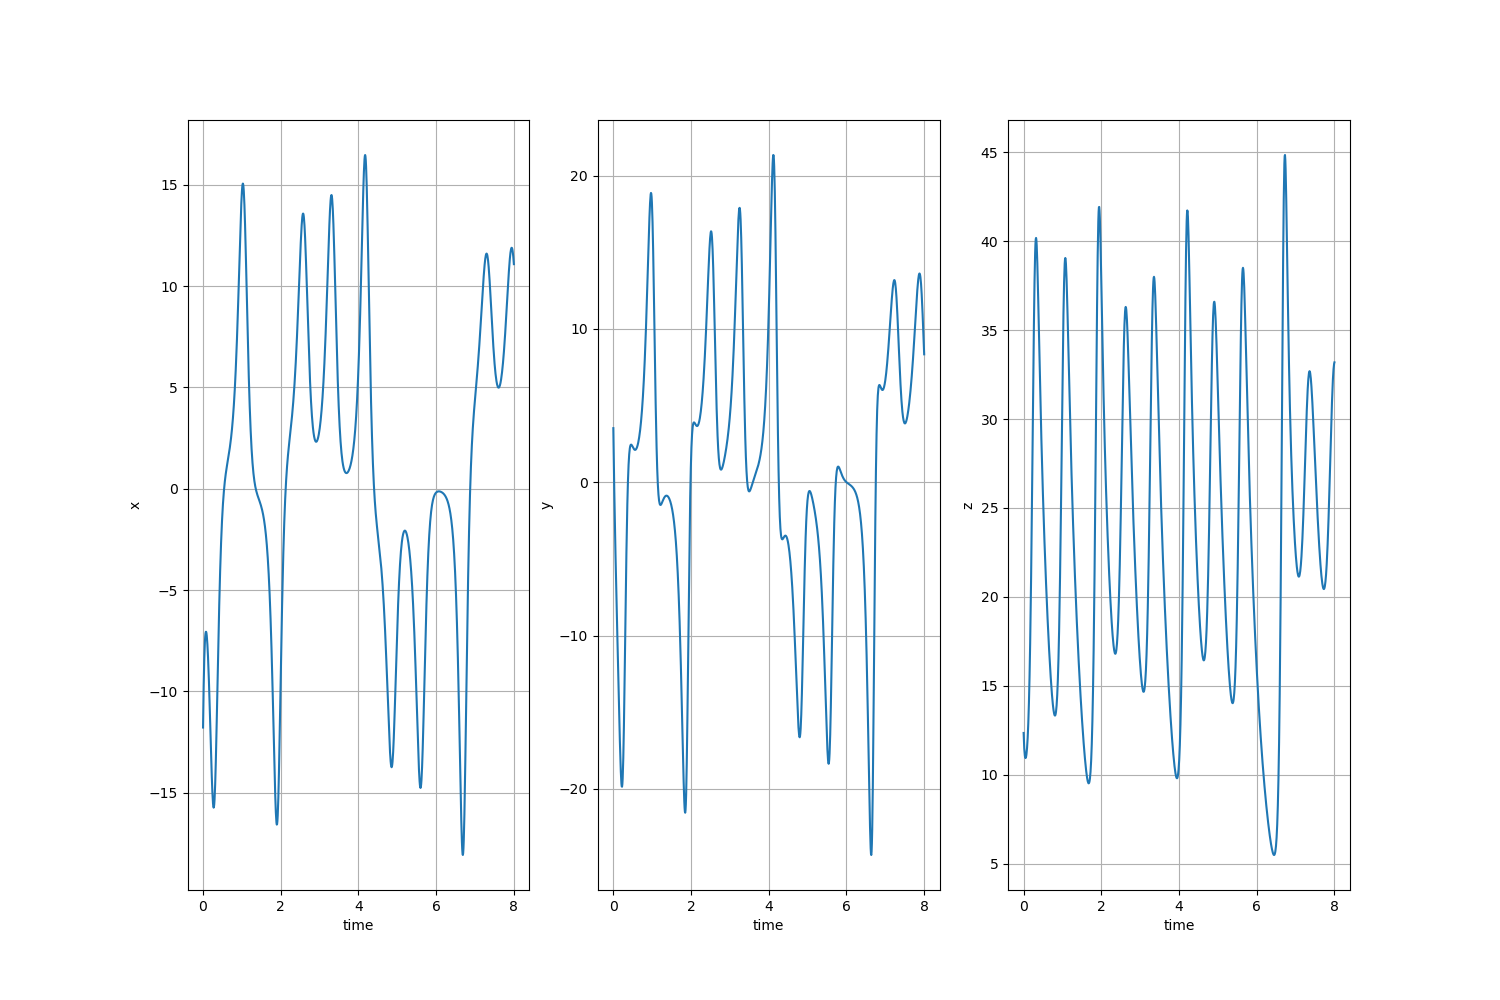

In [20]:
# plot components
plot_components(X, Y)

## Define the model
This is inspired by the tuned model on DHO

In [21]:
# Model class
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 3))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [22]:
n_layers = 4
n_neurons = 28
n_epochs = 10000
# create model
short_model = FFNN(n_layers, n_neurons)

## Short model 

In [23]:
history_PINN = []

In [24]:
# define the optimizer
optimizer = torch.optim.Adam(short_model.parameters(), lr=0.001)
# add minimun to lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1000, min_lr=1e-5)

# define the loss function, L2
loss_fn = torch.nn.MSELoss()


In [25]:
# select only time < 2
X_sub = X[X<0.26]
Y_sub = Y[X<0.26]

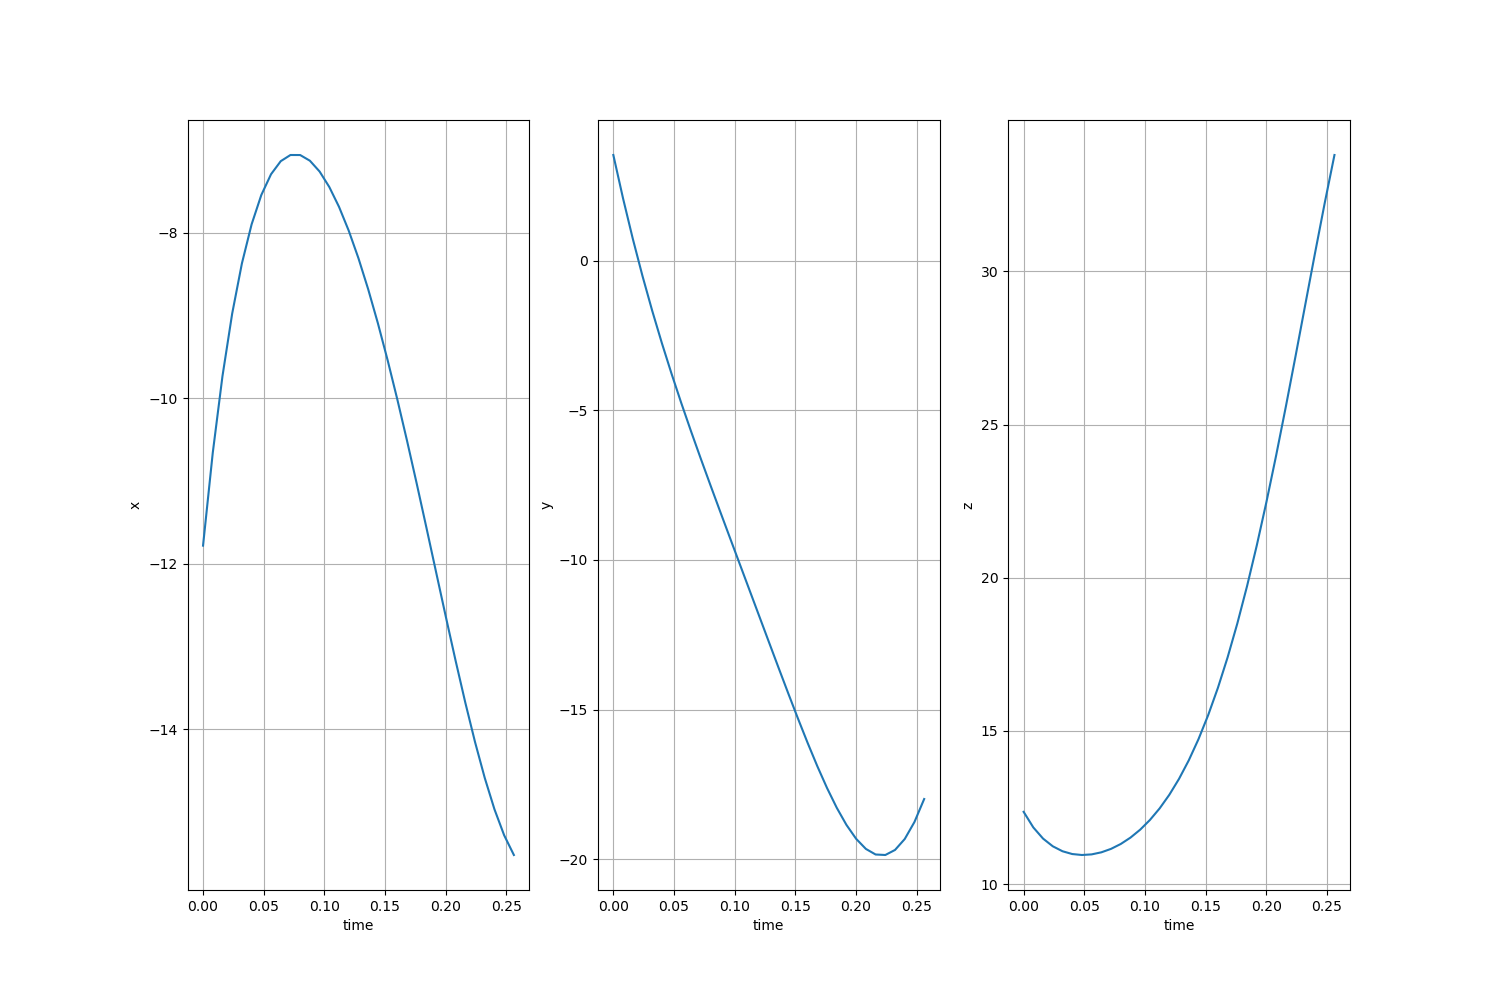

In [26]:
# plot components
plot_components(X_sub, Y_sub)

In [27]:
# to torch
X_sub_t = torch.tensor(X_sub, dtype=torch.float32).view(-1, 1)
Y_sub_t = torch.tensor(Y_sub, dtype=torch.float32)


3*250000

In [38]:
%%time

for epoch in range(3*250000):
    optimizer.zero_grad()
    X_sub_t.requires_grad = True
    Y_pred = short_model(X_sub_t)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

    # add loss ic
    loss_ic = torch.mean((Y_pred[0] - Y_sub_t[0])**2)

    loss = 20*loss_ode + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    history_PINN.append([loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"]])    

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss 0.26342737674713135, lr 0.0004096000000000001
Epoch 1000, Loss 0.484549343585968, lr 0.0004096000000000001
Epoch 2000, Loss 0.2737593352794647, lr 0.0004096000000000001
Epoch 3000, Loss 0.3397865891456604, lr 0.0004096000000000001
Epoch 4000, Loss 0.2481081336736679, lr 0.0004096000000000001
Epoch 5000, Loss 0.26107338070869446, lr 0.0004096000000000001
Epoch 6000, Loss 0.6151490807533264, lr 0.0004096000000000001
Epoch 7000, Loss 0.310327410697937, lr 0.0004096000000000001
Epoch 8000, Loss 0.41346481442451477, lr 0.0004096000000000001
Epoch 9000, Loss 0.23382900655269623, lr 0.0004096000000000001
Epoch 10000, Loss 0.8320176005363464, lr 0.0004096000000000001
Epoch 11000, Loss 0.25102561712265015, lr 0.0004096000000000001
Epoch 12000, Loss 0.35422852635383606, lr 0.0004096000000000001
Epoch 13000, Loss 0.25925007462501526, lr 0.0004096000000000001
Epoch 14000, Loss 0.5006727576255798, lr 0.0004096000000000001
Epoch 15000, Loss 0.542710542678833, lr 0.0004096000000000001
E

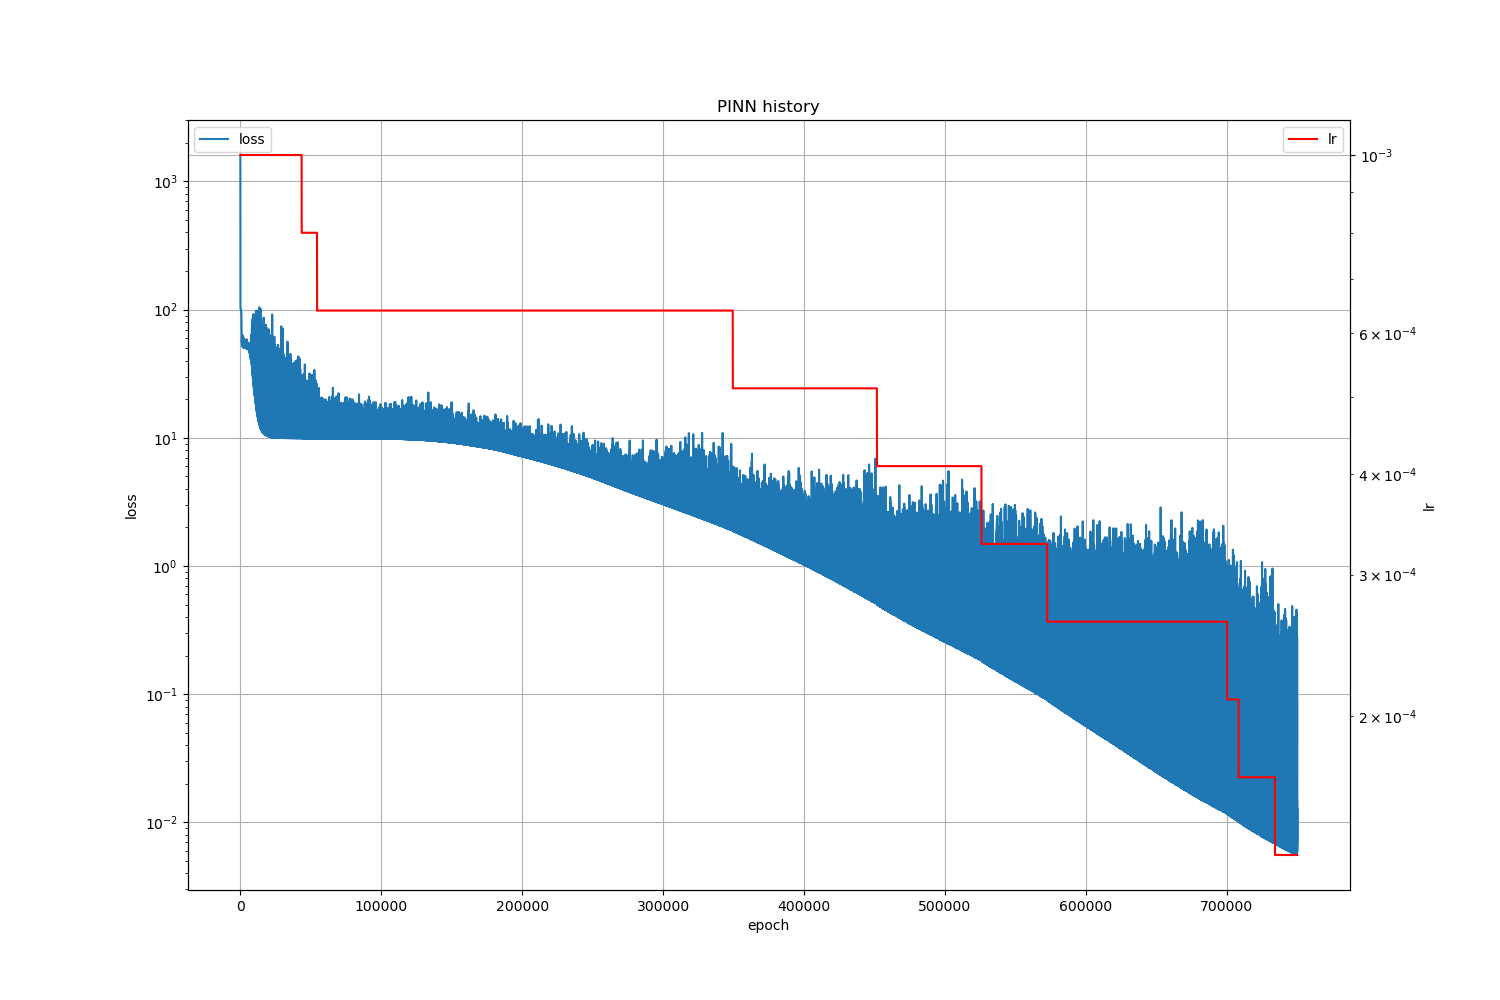

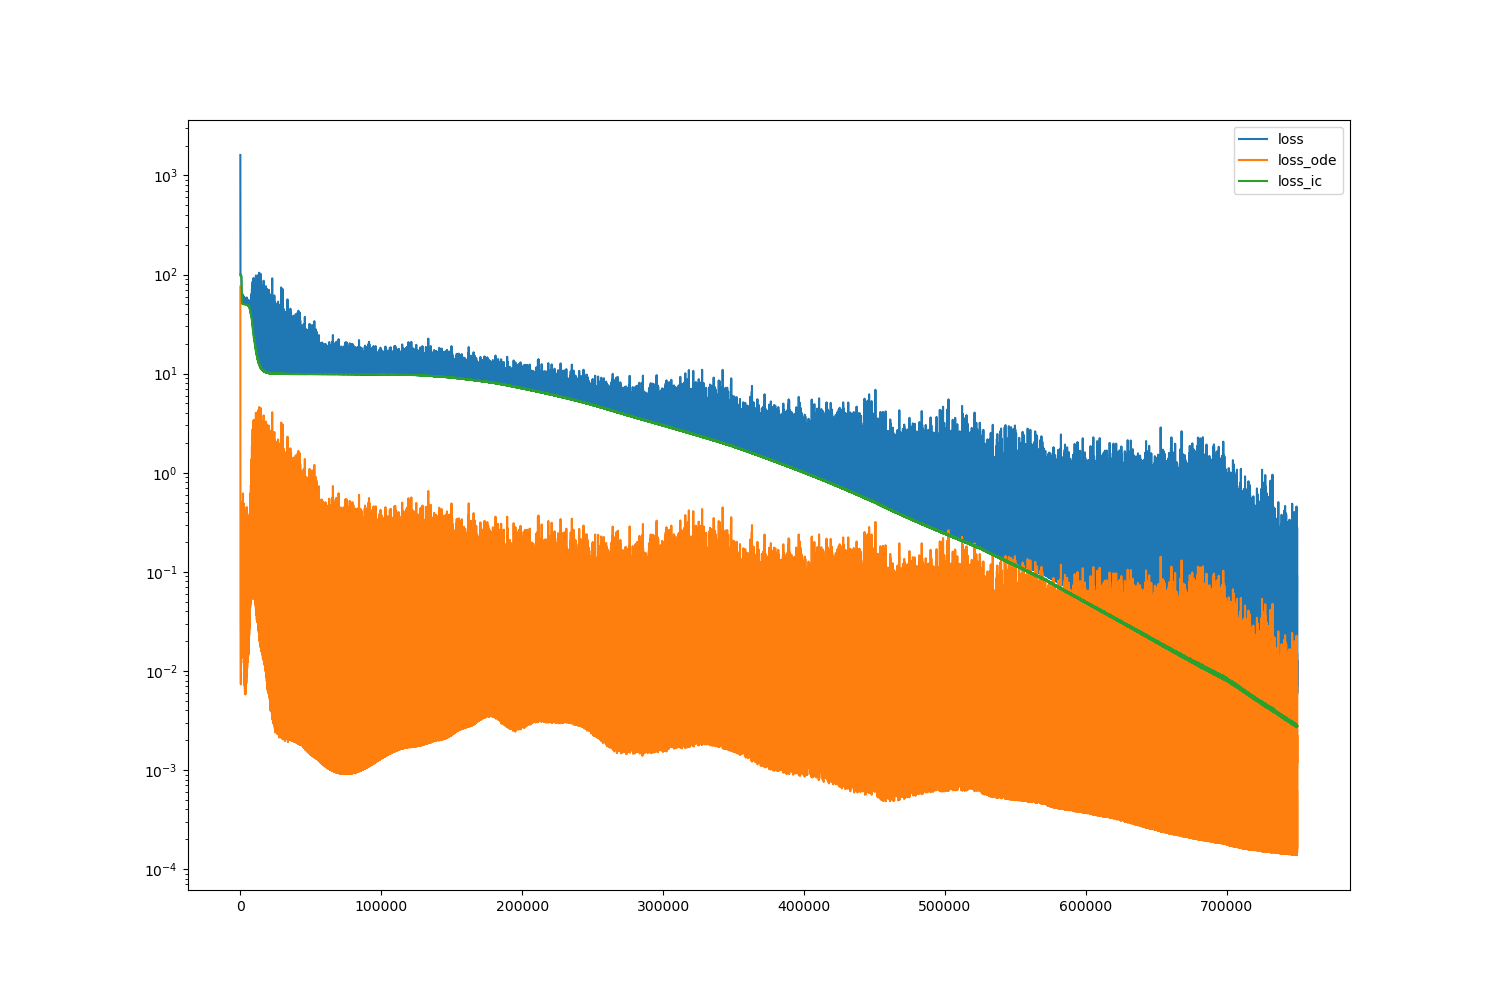

In [39]:
# plot history_PINN loss and lr in two subplots
history_PINN = np.array(history_PINN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')


# plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN[:, 0], label='loss')
plt.plot(history_PINN[:, 1], label='loss_ode')
plt.plot(history_PINN[:, 2], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN = history_PINN.tolist()

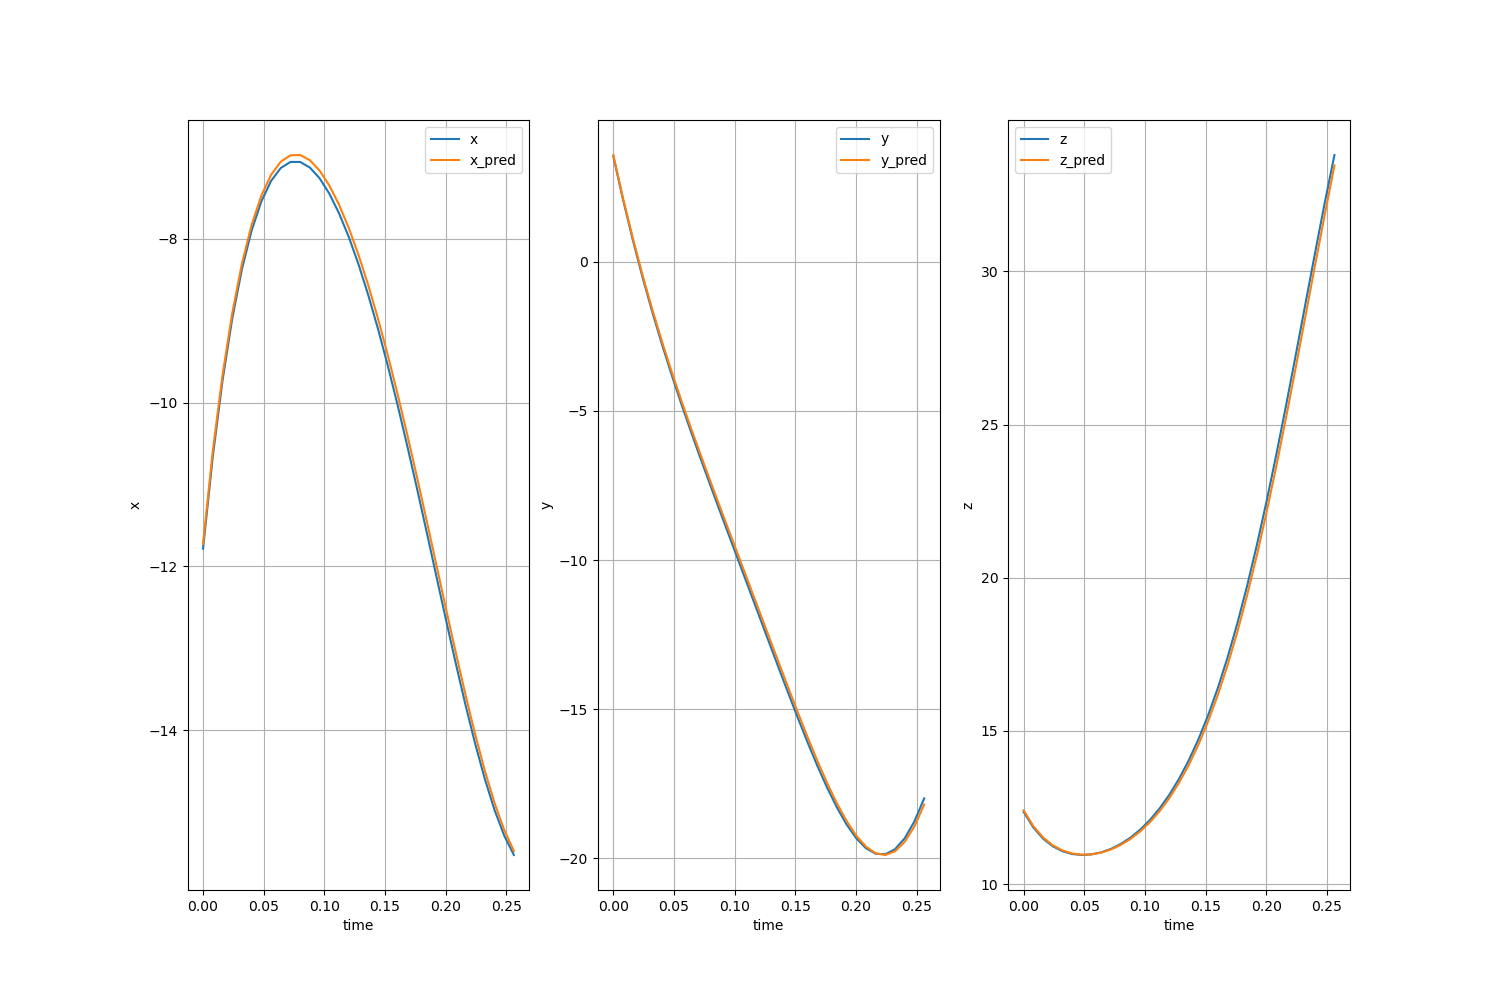

In [40]:
# get prediction and plot compare
Y_pred = short_model(X_sub_t).detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred)

## Long model
Starting with the same model, already trained on the short time span, we will train the model on the time span (0,1). Note that the epochs are 3x the short model.

In [42]:
# define the optimizer
optimizer = torch.optim.Adam(short_model.parameters(), lr=0.001)
# add minimun to lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=1000, min_lr=1e-5)

# define the loss function, L2
loss_fn = torch.nn.MSELoss()


In [56]:
# select only time < 2
X_sub = X[X<1]
Y_sub = Y[X<1]

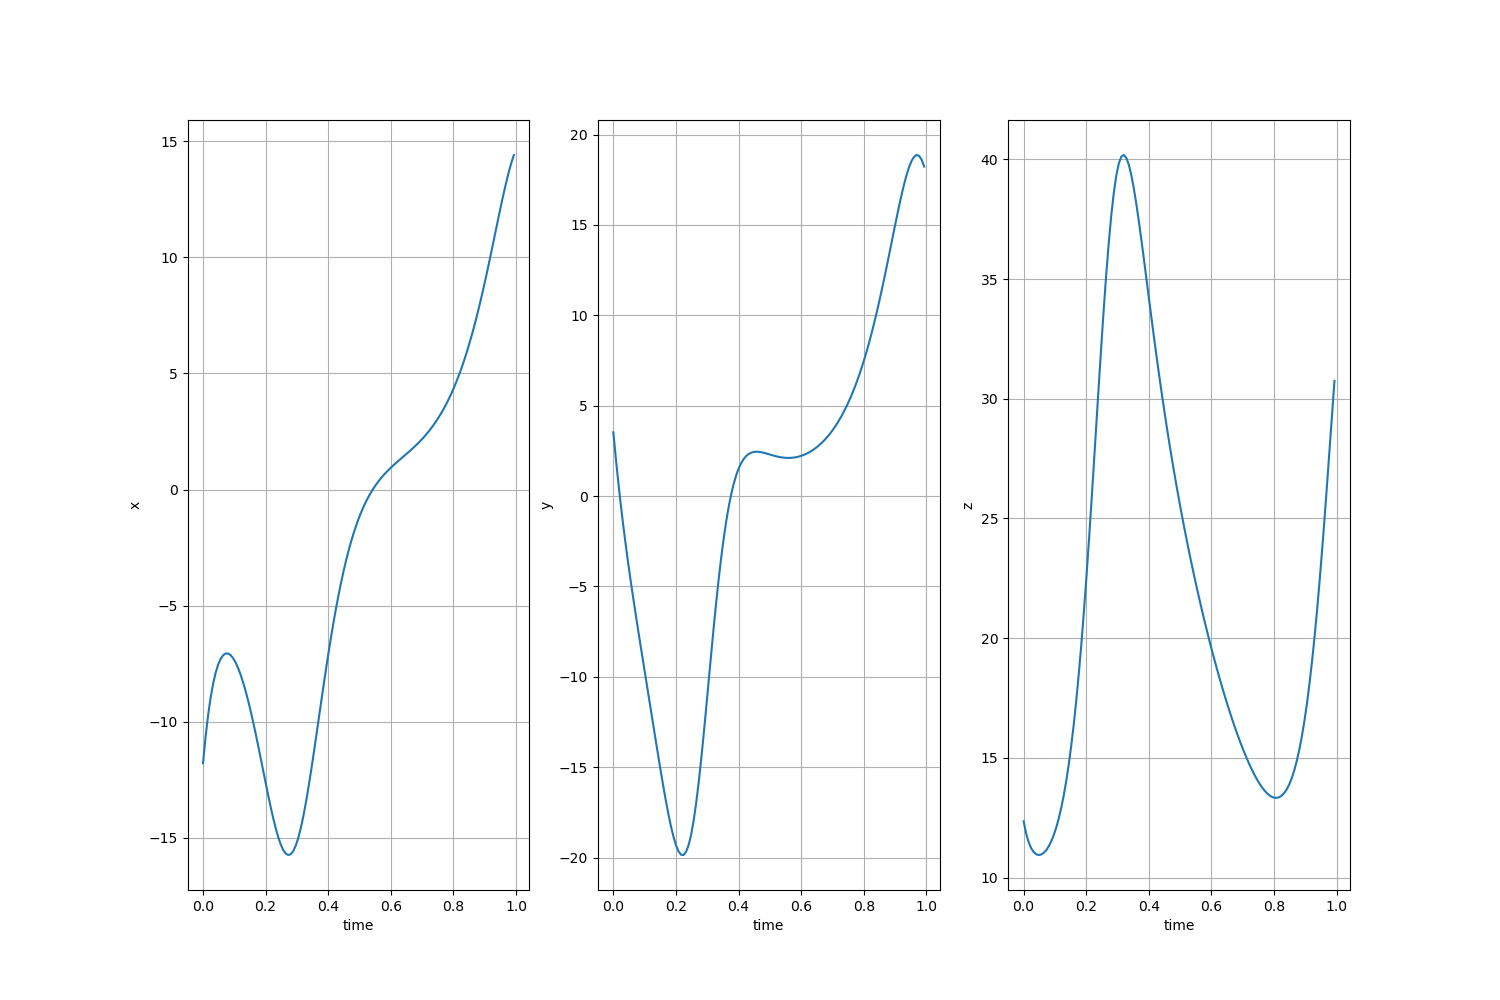

In [57]:
# plot components
plot_components(X_sub, Y_sub)

In [58]:
# to torch
X_sub_t = torch.tensor(X_sub, dtype=torch.float32).view(-1, 1)
Y_sub_t = torch.tensor(Y_sub, dtype=torch.float32)


In [46]:
%%time

for epoch in range(9*250000):
    optimizer.zero_grad()
    X_sub_t.requires_grad = True
    Y_pred = short_model(X_sub_t)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X_sub_t, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 10 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = loss_fn(dx_dt_pred[:,0], dx_dt_ode) + loss_fn(dy_dt_pred[:,0], dy_dt_ode) + loss_fn(dz_dt_pred[:,0], dz_dt_ode)

    # add loss ic
    loss_ic = torch.mean((Y_pred[0] - Y_sub_t[0])**2)

    loss = 20*loss_ode + loss_ic

    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    history_PINN.append([loss.item(), loss_ode.detach().numpy(), loss_ic.detach().numpy(), optimizer.param_groups[0]["lr"]])    

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}, lr {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss 626389.5, lr 0.001
Epoch 1000, Loss 145.3151092529297, lr 0.001
Epoch 2000, Loss 125.38775634765625, lr 0.001
Epoch 3000, Loss 119.87185668945312, lr 0.001
Epoch 4000, Loss 111.70367431640625, lr 0.001
Epoch 5000, Loss 104.68612670898438, lr 0.001
Epoch 6000, Loss 99.33305358886719, lr 0.001
Epoch 7000, Loss 85.5203857421875, lr 0.001
Epoch 8000, Loss 82.61097717285156, lr 0.001
Epoch 9000, Loss 80.74768829345703, lr 0.001
Epoch 10000, Loss 81.3205795288086, lr 0.001
Epoch 11000, Loss 74.30023193359375, lr 0.001
Epoch 12000, Loss 68.00859832763672, lr 0.001
Epoch 13000, Loss 59.172706604003906, lr 0.001
Epoch 14000, Loss 51.27915573120117, lr 0.001
Epoch 15000, Loss 40.913787841796875, lr 0.001
Epoch 16000, Loss 33.425106048583984, lr 0.001
Epoch 17000, Loss 27.24936866760254, lr 0.001
Epoch 18000, Loss 22.314571380615234, lr 0.001
Epoch 19000, Loss 18.15882682800293, lr 0.001
Epoch 20000, Loss 16.817596435546875, lr 0.001
Epoch 21000, Loss 11.265545845031738, lr 0.001
Ep

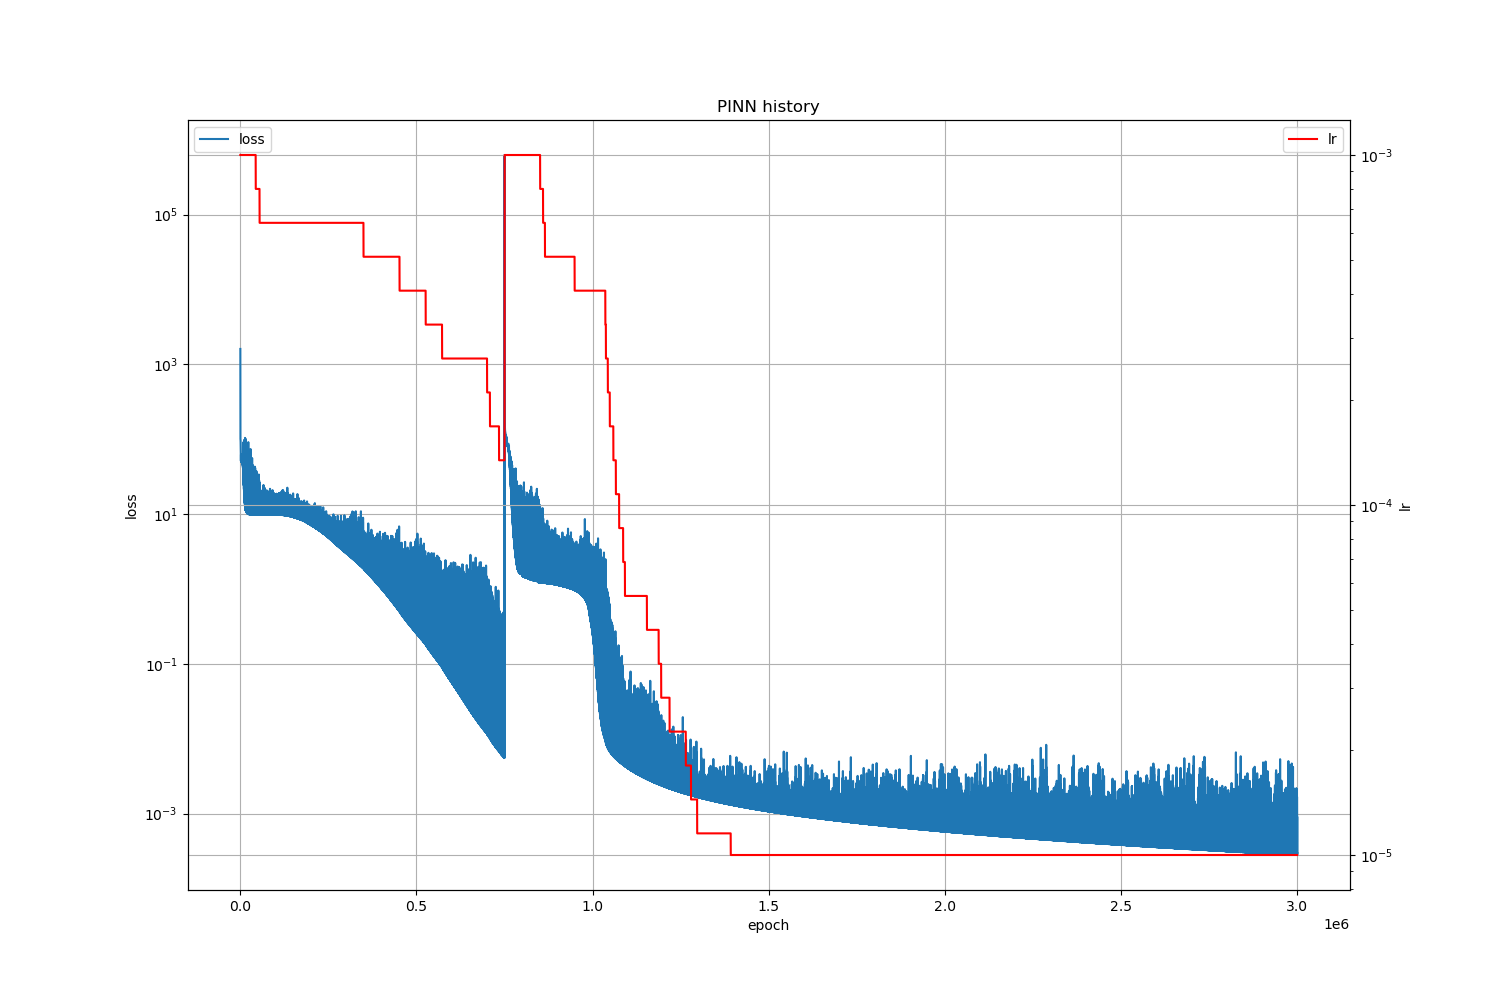

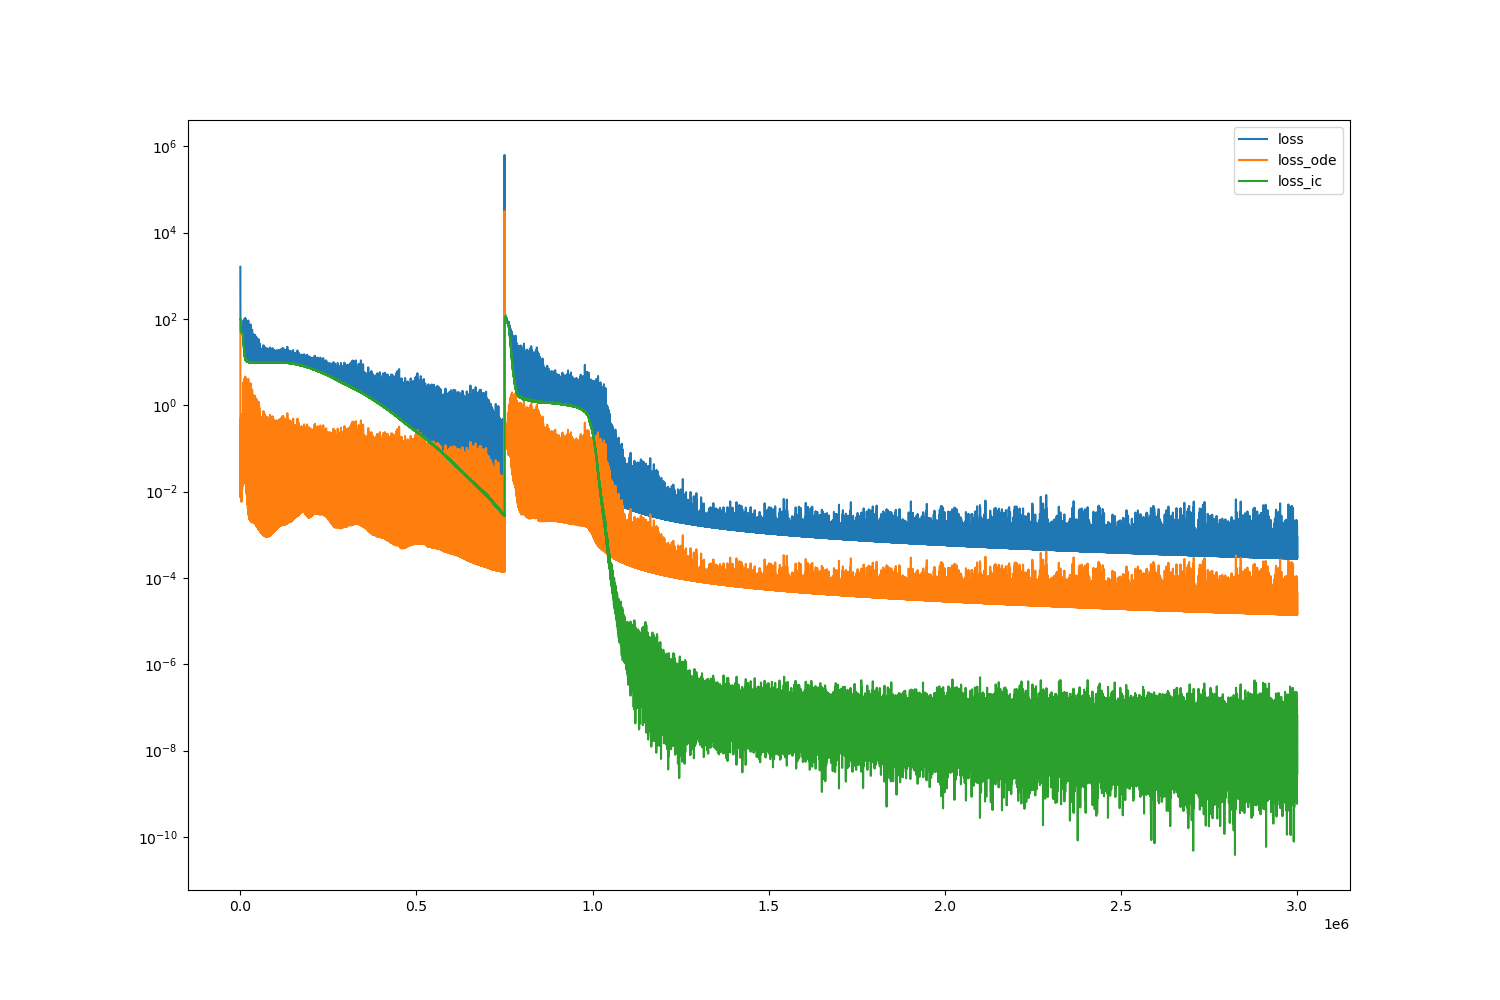

In [76]:
# plot history_PINN loss and lr in two subplots
history_PINN = np.array(history_PINN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')
# save fig
plt.savefig('../plot/lorenz_long_hostory.pdf')


# plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN[:, 0], label='loss')
plt.plot(history_PINN[:, 1], label='loss_ode')
plt.plot(history_PINN[:, 2], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN = history_PINN.tolist()


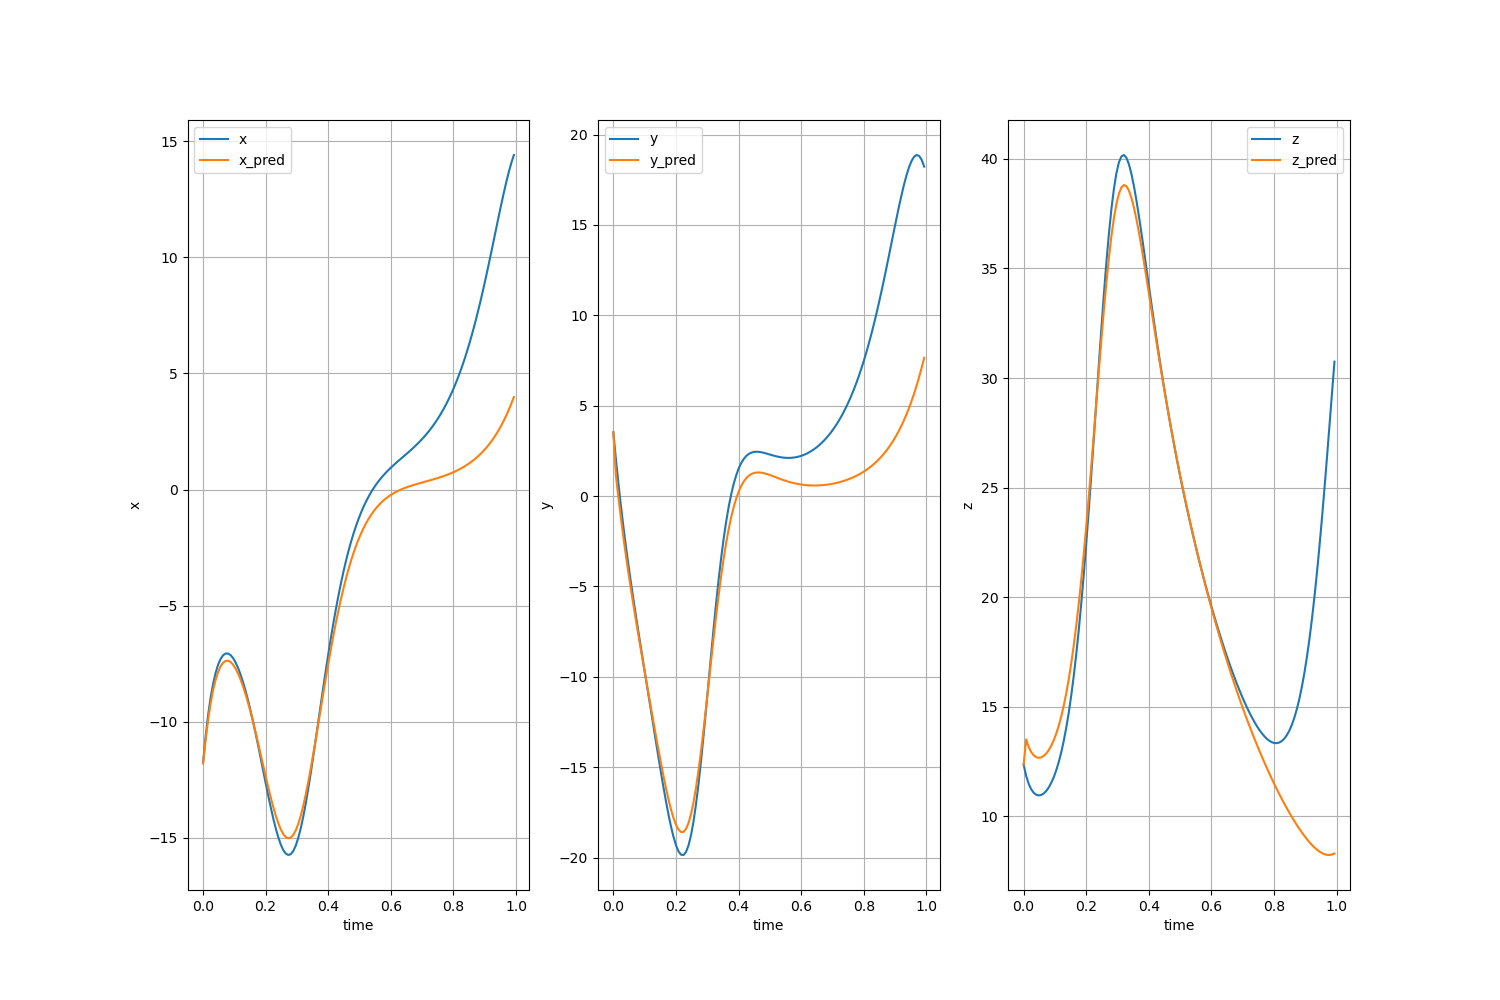

In [48]:
# get prediction and plot compare
Y_pred = short_model(X_sub_t).detach().numpy()
plot_compare_components(X_sub, Y_sub, Y_pred)

In [50]:
# def a function called ode_loss
def lorenz_loss_ode(model, X):
    """
    This function calculates the loss of the ode for the Lorenz system
    as a function of the input tensor X (time).
    Parameters:
    model (torch.nn.Module): the model
    X (torch.tensor): the input tensor
    """

    X.requires_grad = True
    Y_pred = model(X)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 20 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = (dx_dt_pred[:,0]- dx_dt_ode)**2 + (dy_dt_pred[:,0]- dy_dt_ode)**2 + (dz_dt_pred[:,0]- dz_dt_ode)**2

    return loss_ode

Text(0.5, 1.0, 'loss ode')

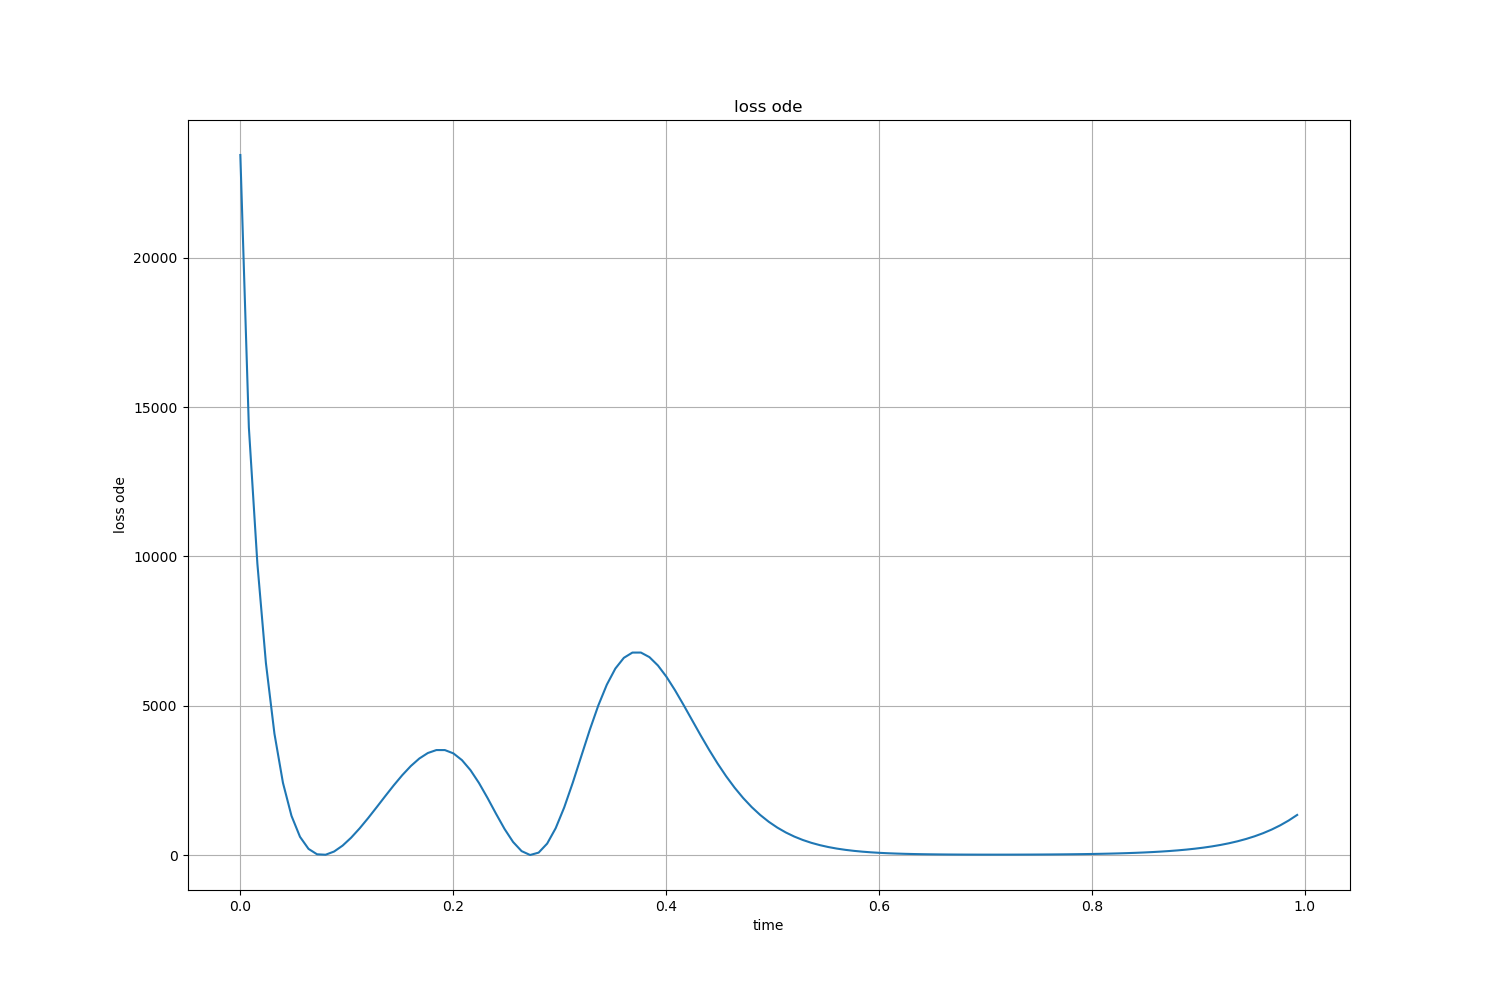

In [74]:
# get loss ode
loss_ode = lorenz_loss_ode(short_model, X_sub_t)
# plot loss ode
plt.figure(figsize=(15, 10))
plt.plot(X_sub, loss_ode.detach().numpy())
plt.ylabel('loss ode')
plt.xlabel('time')
plt.grid()
plt.title('loss ode')

In [71]:
# def func plot_propagation, with max index -> Y0_index
def plot_propagation(X, Y_true, Y_pred, Y0_index):
    """
    This function compare predicted and true solution of the lorenz system,
    in addition there is the solution (with solve_ivp) propagated from the predicted state at the Y0_index.
    Parameters:
    X (array): time
    Y_true (array): true state
    Y_pred (array): predicted state
    Y0_index (int): index of the predicted state to be used as initial condition
    """

    # get the predicted state for the maximum index
    Y0 = Y_pred[Y0_index]

    # evove with the lorenz function, use scipy ivp_solve
    sol = sp.integrate.solve_ivp(lorenz, [X[Y0_index], 1], Y0, t_eval=X[Y0_index:])

    # plot the solution
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(sol.t, sol.y[0], label='x_prop', marker='o')
    # plot the predicted solution
    plt.plot(X, Y_pred[:,0], label='x_pred')
    # plot x real
    plt.plot(X, Y_true[:,0], label='x_real')
    # red dot in the maximum index
    plt.plot(X[Y0_index], Y_pred[Y0_index,0], 'ro')
    plt.ylabel('x')
    plt.xlabel('t')
    plt.legend()
    plt.grid()

    # do all the same for y
    plt.subplot(132)
    plt.plot(sol.t, sol.y[1], label='y_prop', marker='o')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.plot(X, Y_true[:,1], label='y_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,1], 'ro')
    plt.ylabel('y')
    plt.xlabel('t')
    plt.grid()

    # do all the same for z
    plt.subplot(133)
    plt.plot(sol.t, sol.y[2], label='z_prop', marker='o')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.plot(X, Y_true[:,2], label='z_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,2], 'ro')
    plt.ylabel('z')
    plt.xlabel('t')
    plt.grid()



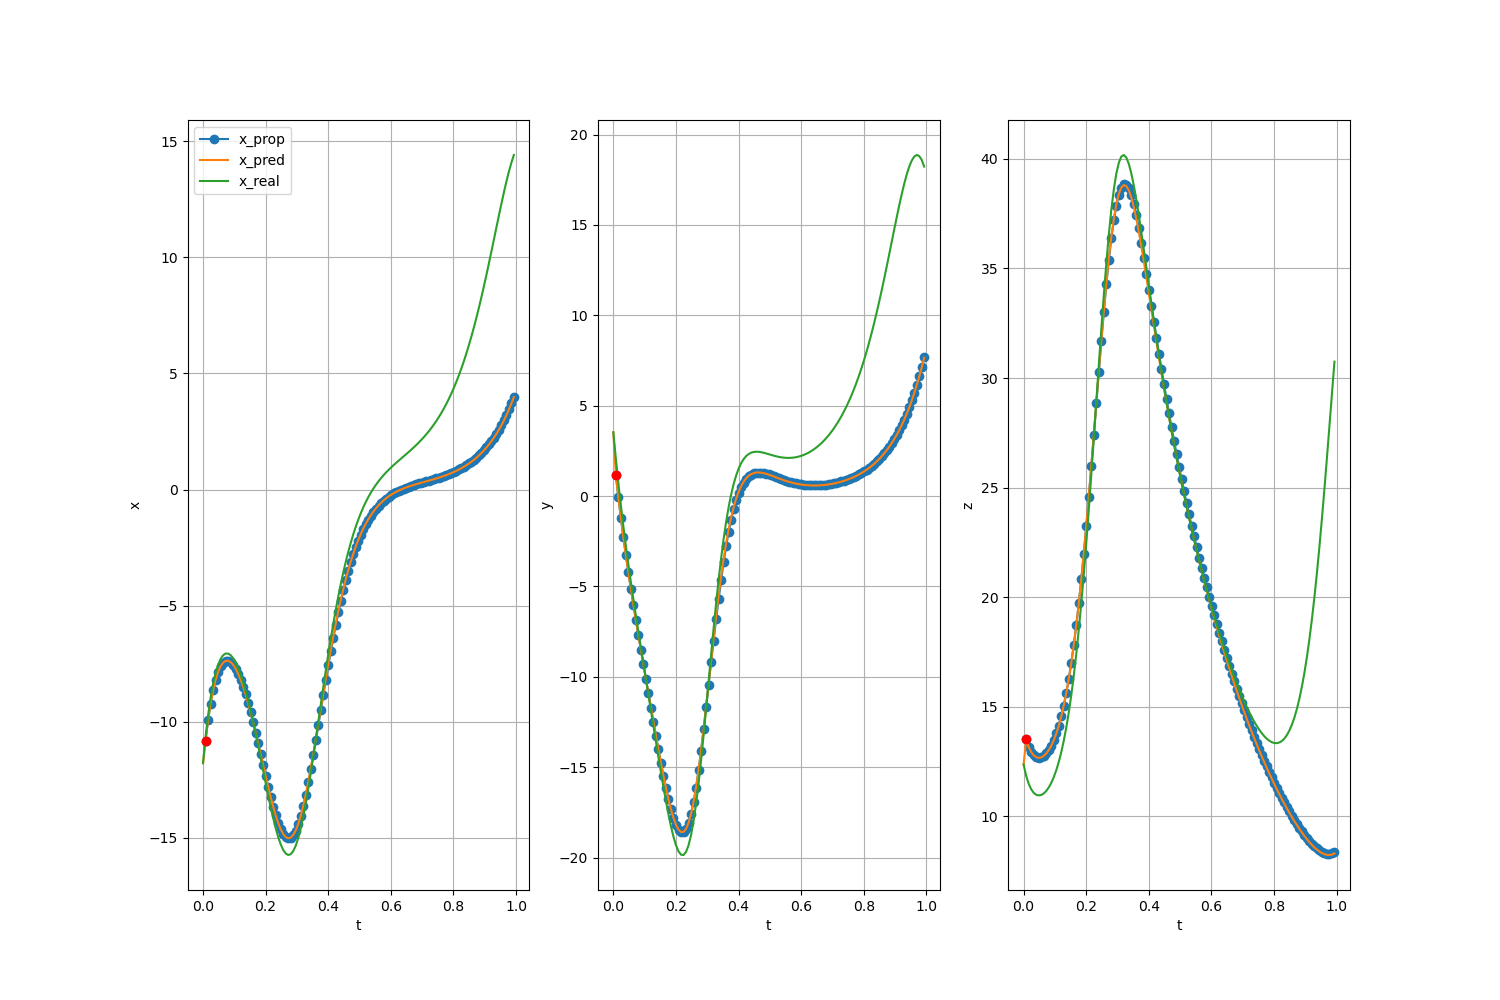

In [72]:
# plot propagation, index 30

plot_propagation(X_sub, Y_sub, Y_pred, 1)

In [35]:
0.025/0.008

3.125

In [18]:
history_PINN = np.array(history_PINN)
# get losses
losses = history_PINN[:, 0]
losses_ode = history_PINN[:, 1]
losses_ic = history_PINN[:, 2]

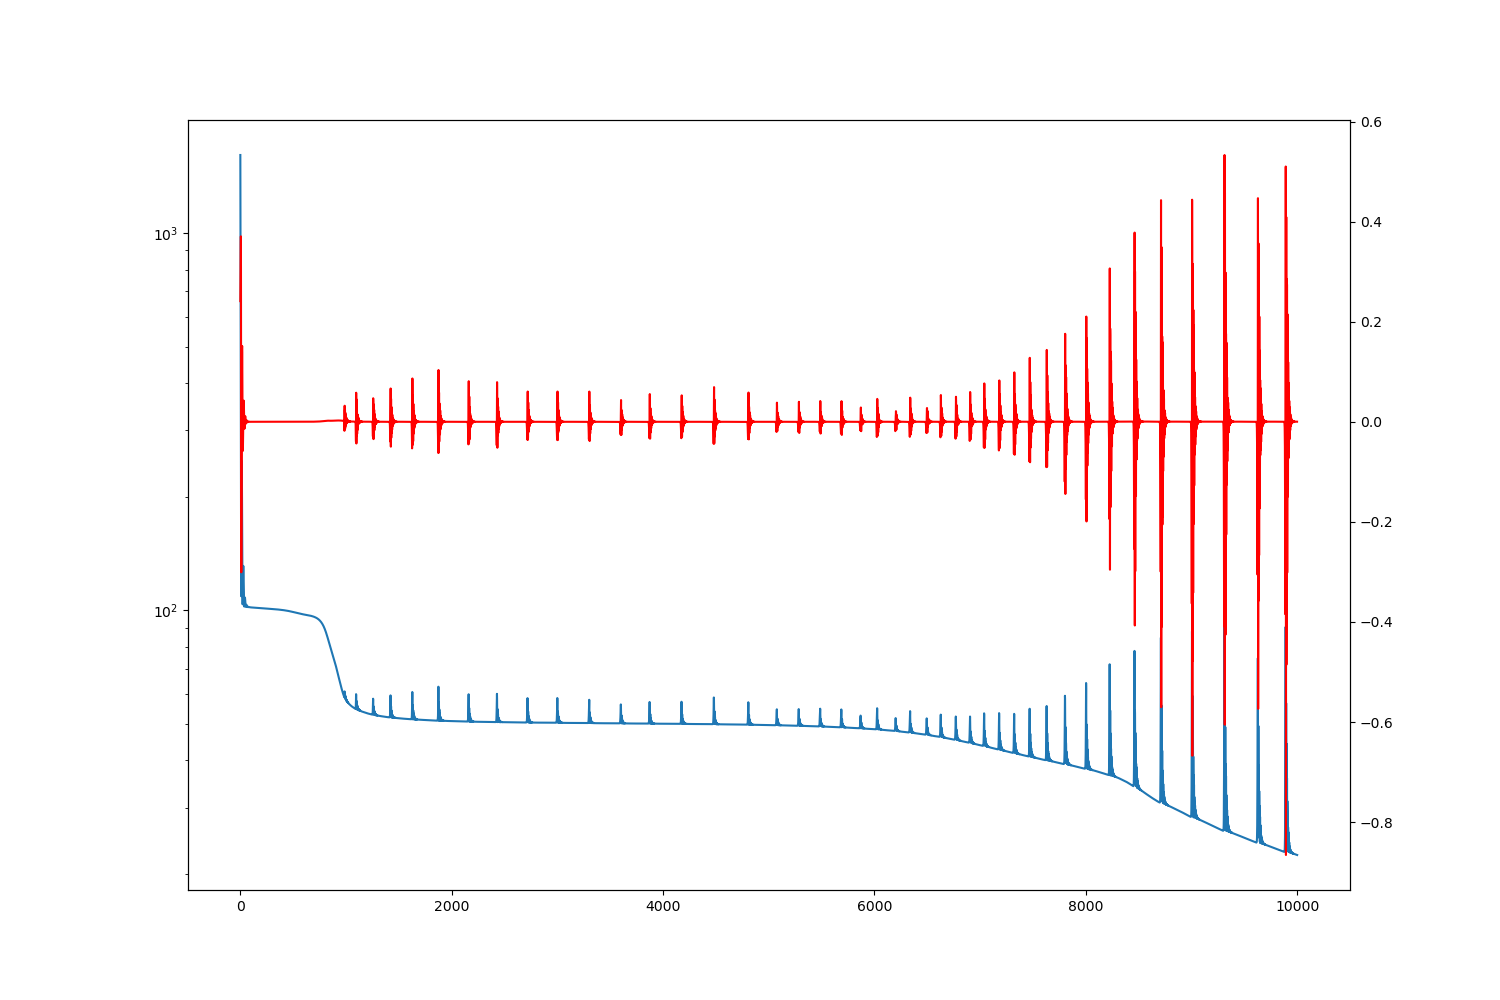

In [19]:
# get derivative of the losses
d_losses = np.diff(losses)
d_losses_ode = np.diff(losses_ode)
d_losses_ic = np.diff(losses_ic)

# get normalized derivative of the losses
d_losses_norm = d_losses / losses[:-1]
d_losses_ode_norm = d_losses_ode / losses_ode[:-1]
d_losses_ic_norm = d_losses_ic / losses_ic[:-1]

# twin plot of the losses and in the other axis the derivative of the losses
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(losses, label='loss')
plt.yscale('log')

ax2 = ax.twinx()
ax2.plot(-d_losses_norm, label='d_loss', color='r')


In [ ]:
d_losses_ode

array([-6.13320007e+01,  2.10404396e-01, -5.50914526e+00, ...,
        6.33057061e-06,  5.48219396e-06,  1.55865564e-06])

In [ ]:
# plot d_losses_ode
plt.figure(figsize=(15, 10))
plt.plot(d_losses_ode, label='d_losses_ode')
plt.yscale('log')

: 

## Results

### Short model
This model was being trained on the timespan (0, 0.25) for approx 30 min.

In [113]:
# load PINN_Lorenz_model_14_3_T_0_0.25.pt
model_short = torch.load('../models/lorenz_PINN_baseline/lorenz_PINN_baseline_start0_stop0.25.pt')

In [114]:
# select only0.25time < 2
X_temp = X[X<0.25]
Y_temp = Y[X<0.25]

# to torch
X_temp = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
Y_temp = torch.tensor(Y_temp, dtype=torch.float32)

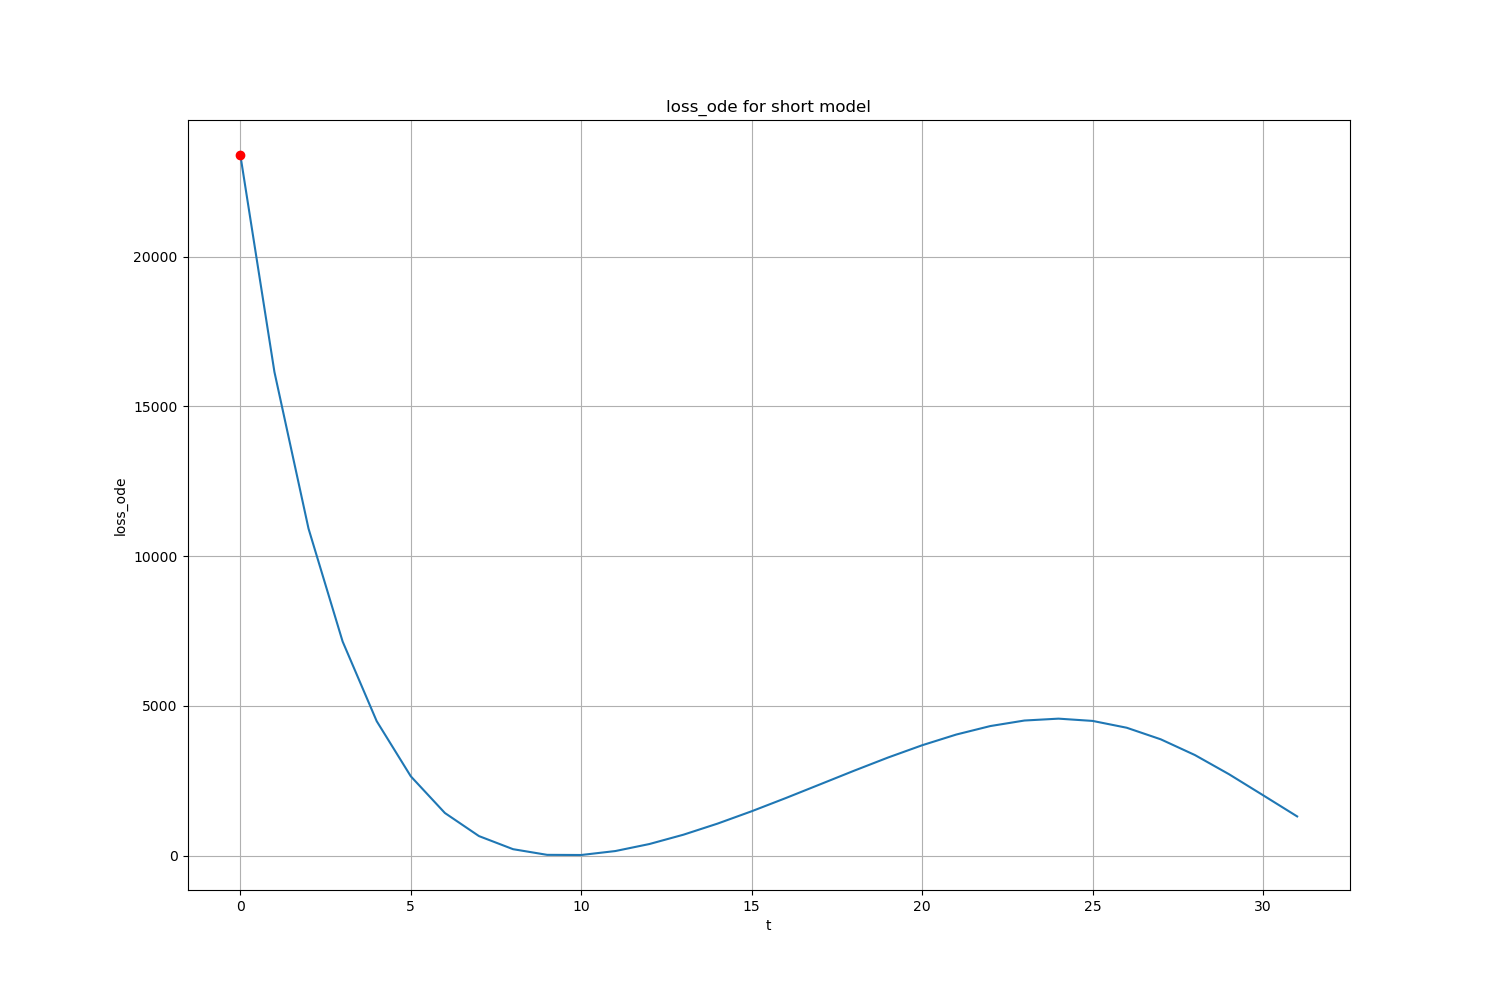

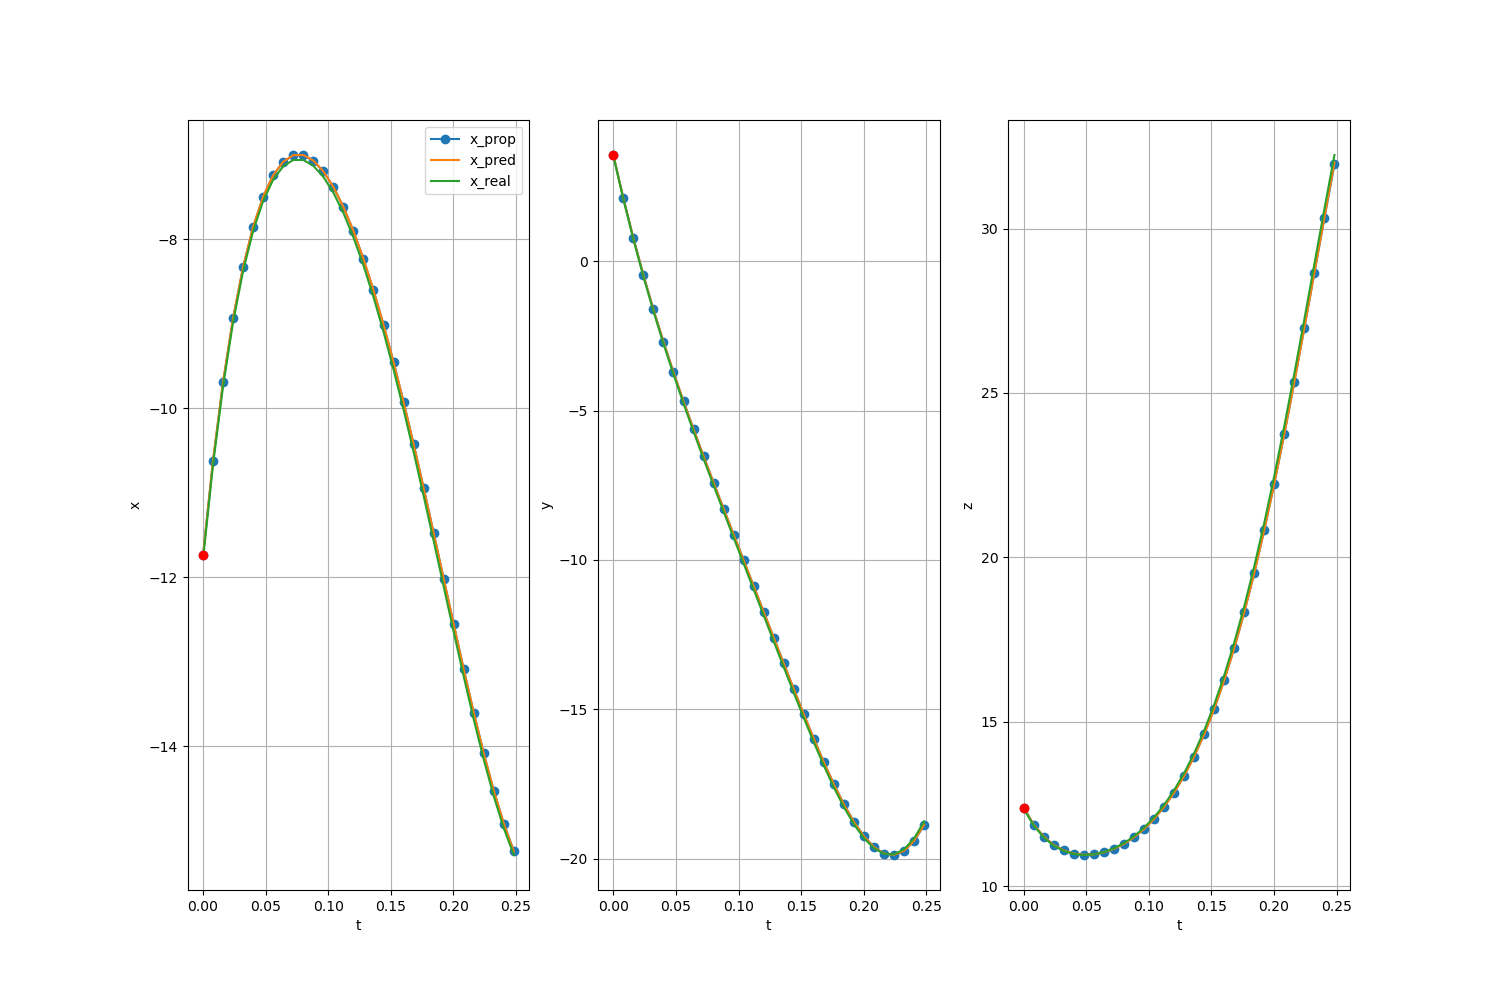

In [115]:
# plot loss ode
loss_ode = lorenz_loss_ode(model_short, X_temp)
plt.figure(figsize=(15, 10))
plt.plot(loss_ode.detach().numpy())
plt.grid()
plt.xlabel('t')
plt.ylabel('loss_ode')
plt.title('loss_ode for short model')

# get the maximum index and plot a red dot
max_index = np.argmax(loss_ode.detach().numpy())
plt.plot(max_index, loss_ode.detach().numpy()[max_index], 'ro')


# plot propagation of the max_index
plot_propagation(X_temp.detach().detach().reshape(-1), Y_temp.detach().numpy(), model_short(X_temp).detach().numpy(), max_index)

In [122]:
Y_pred = model_short(X_temp).detach().numpy()

array([[-11.740672  ,   3.5587404 ,  12.3867855 ],
       [-10.609575  ,   2.1023948 ,  11.870993  ],
       [ -9.684661  ,   0.76795894,  11.505334  ],
       [ -8.928669  ,  -0.47073287,  11.251027  ],
       [ -8.323102  ,  -1.6236899 ,  11.084814  ],
       [ -7.8498726 ,  -2.7036204 ,  10.98909   ],
       [ -7.4937053 ,  -3.7229564 ,  10.952052  ],
       [ -7.2415257 ,  -4.6936655 ,  10.966217  ],
       [ -7.081969  ,  -5.6266756 ,  11.027258  ],
       [ -7.005303  ,  -6.531615  ,  11.133457  ],
       [ -7.003324  ,  -7.41689   ,  11.285211  ],
       [ -7.069112  ,  -8.289647  ,  11.484573  ],
       [ -7.1967583 ,  -9.155628  ,  11.734926  ],
       [ -7.3811417 , -10.019052  ,  12.040742  ],
       [ -7.6177754 , -10.882584  ,  12.407437  ],
       [ -7.9026937 , -11.747332  ,  12.841185  ],
       [ -8.232293  , -12.6126995 ,  13.348719  ],
       [ -8.60312   , -13.47616   ,  13.937083  ],
       [ -9.01168   , -14.333029  ,  14.613404  ],
       [ -9.45429   , -15.17639

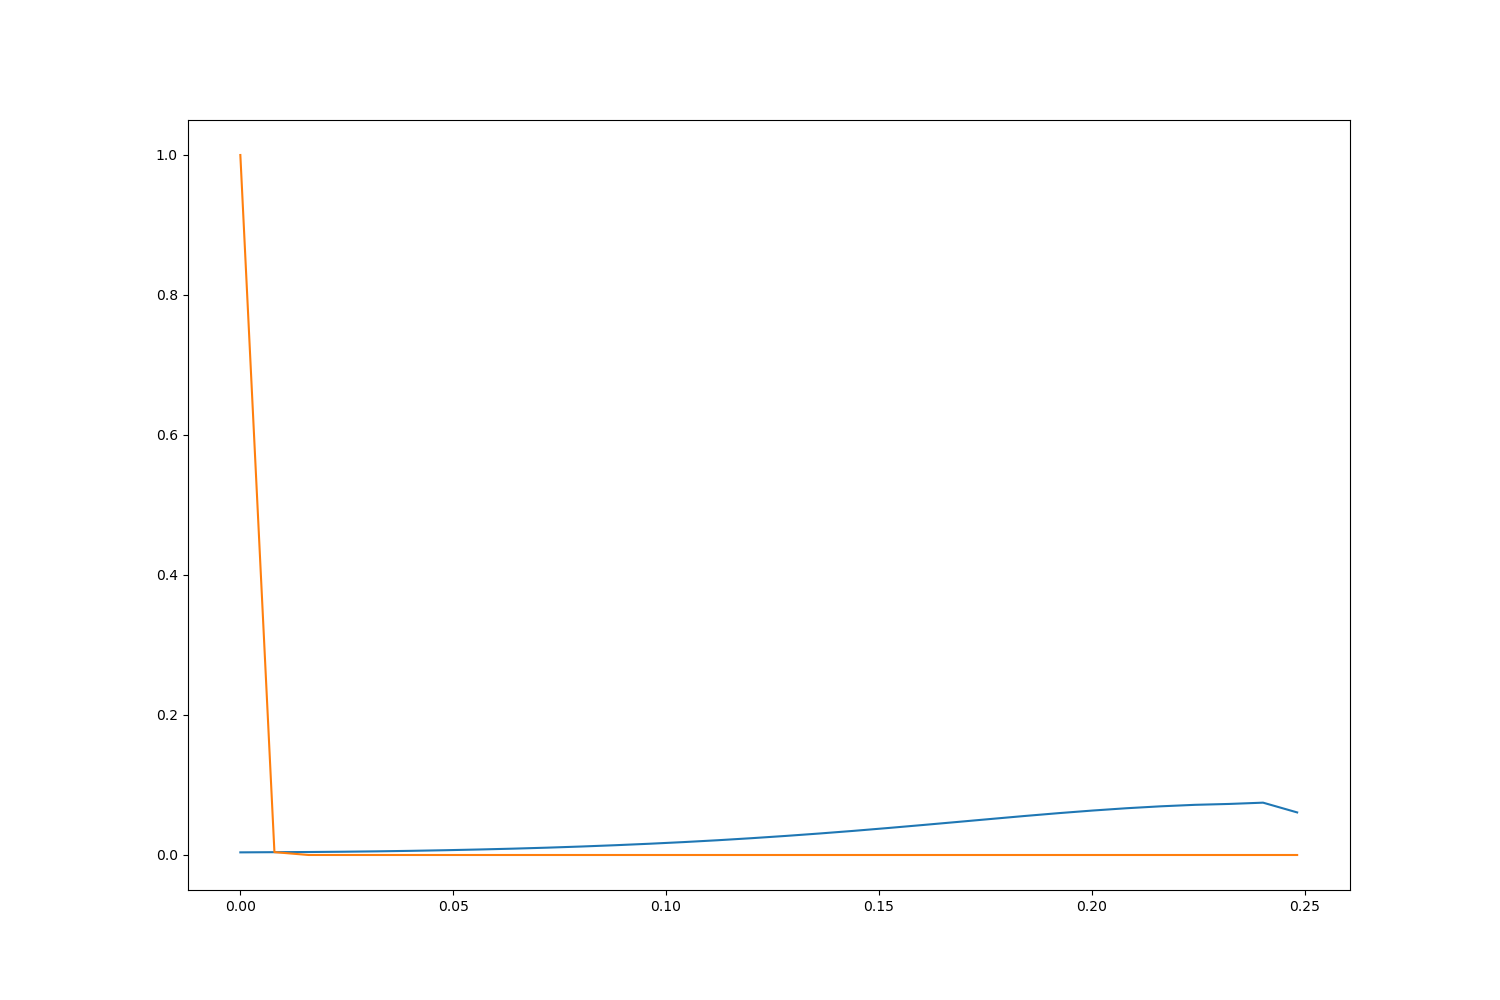

In [130]:
loss = (Y_pred - Y_temp.detach().numpy())**2
# sum along row
loss = np.sum(loss, axis=1)
# plot loss
plt.figure(figsize=(15, 10))
plt.plot(X_temp.detach().numpy(), loss)

# fit an exponential like exp(l*x)
from scipy.optimize import curve_fit

def func(x, l):
    return np.exp(l*x)

popt, pcov = curve_fit(func, X_temp.detach().numpy().reshape(-1), loss)

plt.plot(X_temp.detach().numpy().reshape(-1), func(X_temp.detach().numpy().reshape(-1), *popt))

We see that the maximum of the loss ode is in the beginning of the solution

In [84]:
# load 
loss_fn = torch.nn.MSELoss()

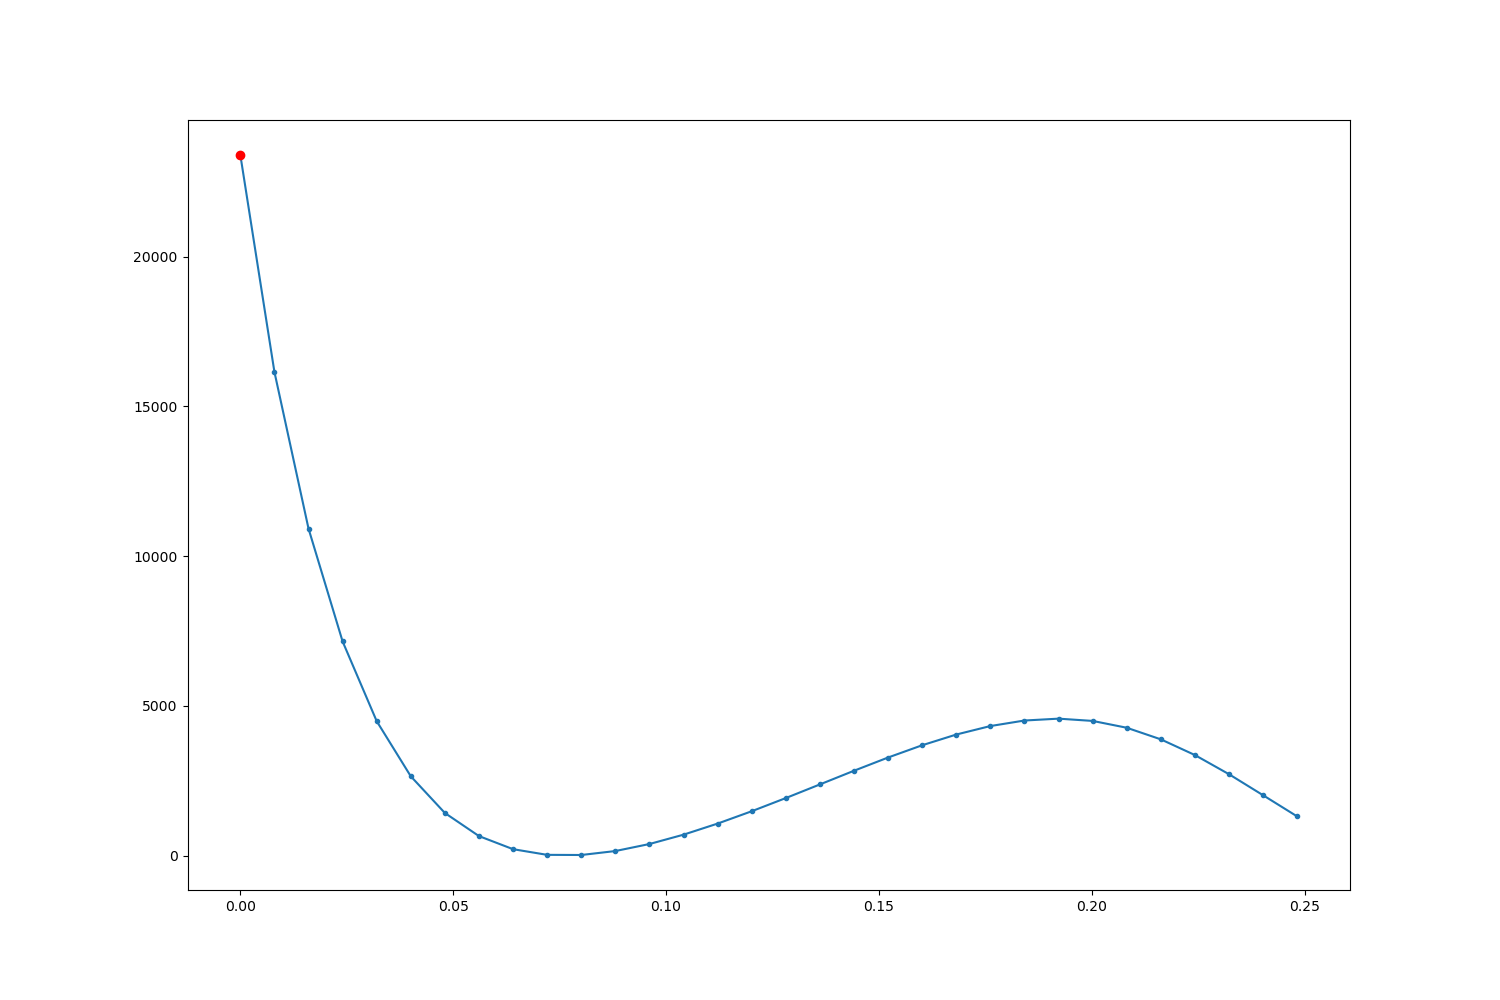

In [67]:
X_sub_t2.requires_grad = True
Y_pred2 = model2(X_sub_t2)

dx_dt_pred2 = torch.autograd.grad(Y_pred2[:,0], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,0]), create_graph=True)[0]
dy_dt_pred2 = torch.autograd.grad(Y_pred2[:,1], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,1]), create_graph=True)[0]
dz_dt_pred2 = torch.autograd.grad(Y_pred2[:,2], X_sub_t2, grad_outputs=torch.ones_like(Y_pred2[:,2]), create_graph=True)[0]

# get true derivatives, using the lorenz parameter
dx_dt_ode2 = 20 * (Y_pred2[:,1] - Y_pred2[:,0])
dy_dt_ode2 = Y_pred2[:,0] * (28 - Y_pred2[:,2]) - Y_pred2[:,1]
dz_dt_ode2 = Y_pred2[:,0] * Y_pred2[:,1] - 8/3 * Y_pred2[:,2]

# loss ode
loss_ode_1 = (dx_dt_pred2[:,0]- dx_dt_ode2)**2 + (dy_dt_pred2[:,0]- dy_dt_ode2)**2 + loss_fn(dz_dt_pred2[:,0], dz_dt_ode2)**2

# plot loss_ode_1
plt.figure(figsize=(15, 10))
plt.plot(X_sub_t2.detach().numpy(),loss_ode_1.detach().numpy(), label='loss_ode_1',marker='.')

# get the maximum index, and plot a red dot
max_index = np.argmax(loss_ode_1.detach().numpy())
plt.plot(X_sub_t2.detach().numpy()[max_index], loss_ode_1.detach().numpy()[max_index], 'ro')


# def a function called ode_loss
def lorenz_loss_ode(model, X):
    """
    This function calculates the loss of the ode for the Lorenz system
    as a function of the input tensor X (time).
    Parameters:
    model (torch.nn.Module): the model
    X (torch.tensor): the input tensor
    """

    X.requires_grad = True
    Y_pred = model(X)

    # get the derivatives
    dx_dt_pred = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
    dy_dt_pred = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]
    dz_dt_pred = torch.autograd.grad(Y_pred[:,2], X, grad_outputs=torch.ones_like(Y_pred[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode = 20 * (Y_pred[:,1] - Y_pred[:,0])
    dy_dt_ode = Y_pred[:,0] * (28 - Y_pred[:,2]) - Y_pred[:,1]
    dz_dt_ode = Y_pred[:,0] * Y_pred[:,1] - 8/3 * Y_pred[:,2]

    # loss ode
    loss_ode = (dx_dt_pred[:,0]- dx_dt_ode)**2 + (dy_dt_pred[:,0]- dy_dt_ode)**2 + (dz_dt_pred[:,0]- dz_dt_ode)**2

    return loss_ode

In [63]:
max_index = 30

X_sub2[max_index]

0.24024024024024024

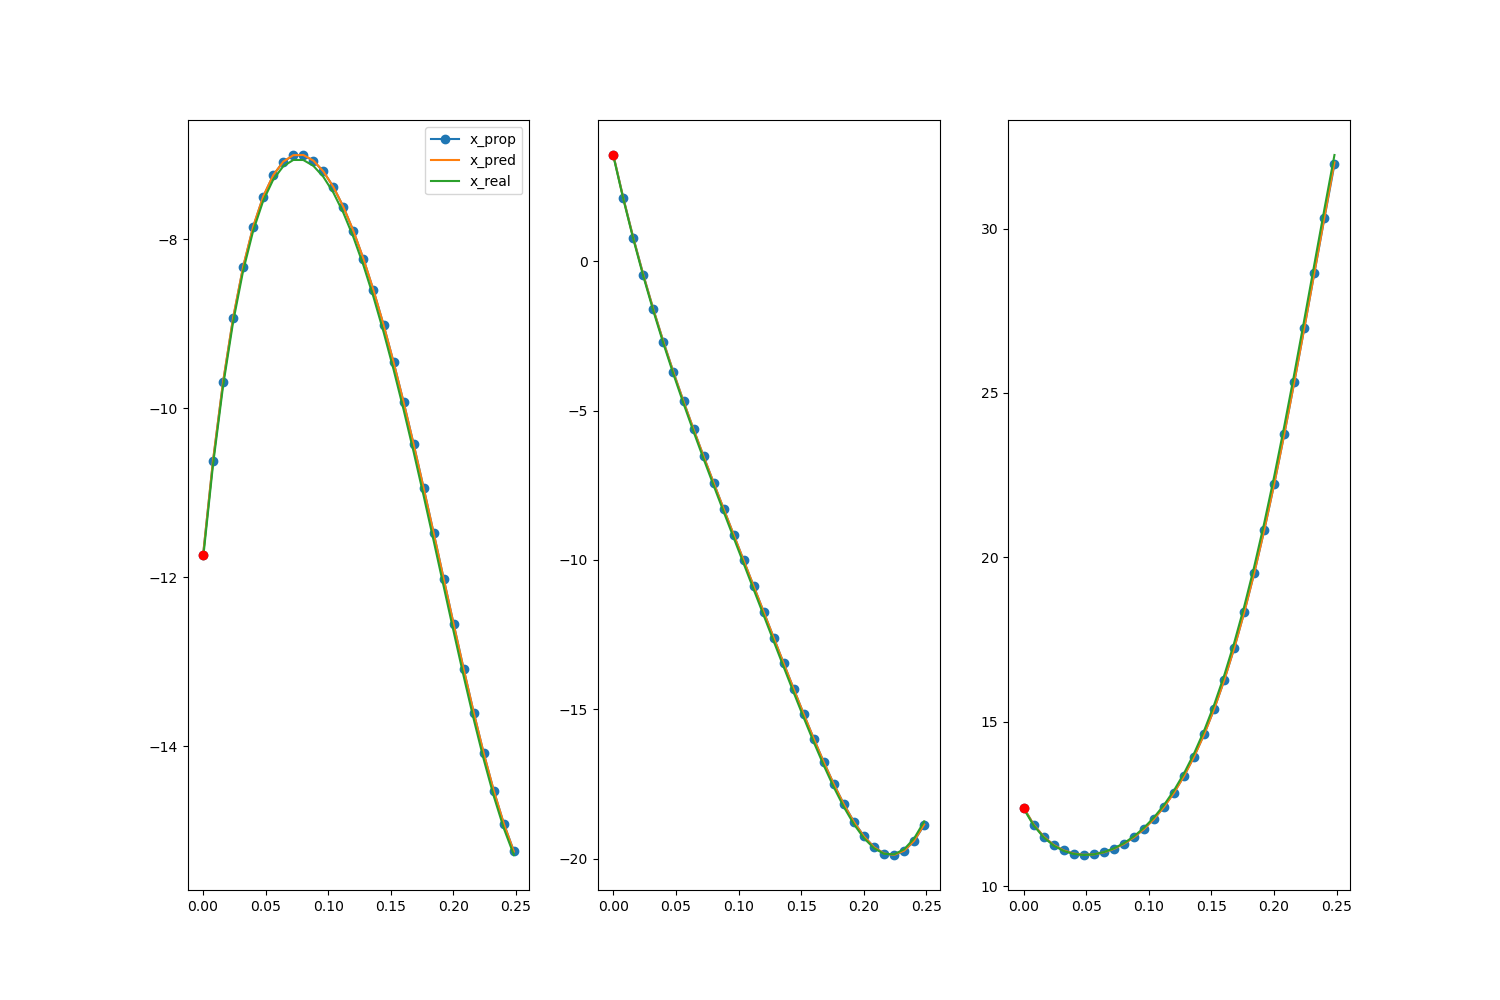

In [68]:
# get the predicted state for the maximum index
Y_pred2[max_index]
# evove with the lorenz function, use scipy ivp_solve
sol_max = sp.integrate.solve_ivp(lorenz, [X_sub2[max_index], 1], Y_pred2.detach().numpy()[max_index], t_eval=X_sub2[max_index:])

# plot the solution
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.plot(sol_max.t, sol_max.y[0], label='x_prop', marker='o')
# plot the predicted solution
plt.plot(X_sub2, Y_pred2.detach().numpy()[:,0], label='x_pred')
# plot x real
plt.plot(X_sub2, Y_sub2[:,0], label='x_real')
# red dot in the maximum index
plt.plot(X_sub2[max_index], Y_pred2.detach().numpy()[max_index,0], 'ro')
plt.legend()

# do all the same for y
plt.subplot(132)
plt.plot(sol_max.t, sol_max.y[1], label='y_prop', marker='o')
plt.plot(X_sub2, Y_pred2.detach().numpy()[:,1], label='y_pred')
plt.plot(X_sub2, Y_sub2[:,1], label='y_real')
plt.plot(X_sub2[max_index], Y_pred2.detach().numpy()[max_index,1], 'ro')

# do all the same for z
plt.subplot(133)
plt.plot(sol_max.t, sol_max.y[2], label='z_prop', marker='o')
plt.plot(X_sub2, Y_pred2.detach().numpy()[:,2], label='z_pred')
plt.plot(X_sub2, Y_sub2[:,2], label='z_real')
plt.plot(X_sub2[max_index], Y_pred2.detach().numpy()[max_index,2], 'ro')


# def func plot_propagation, with max index -> Y0_index
def plot_propagation(X, Y_true, Y_pred, Y0_index):
    """
    This function compare predicted and true solution of the lorenz system,
    in addition there is the solution (with solve_ivp) propagated from the predicted state at the Y0_index.
    Parameters:
    X (array): time
    Y_true (array): true state
    Y_pred (array): predicted state
    Y0_index (int): index of the predicted state to be used as initial condition
    """

    # get the predicted state for the maximum index
    Y0 = Y_pred[Y0_index]

    # evove with the lorenz function, use scipy ivp_solve
    sol = sp.integrate.solve_ivp(lorenz, [X[Y0_index], 1], Y0, t_eval=X[Y0_index:][0])

    # plot the solution
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.plot(sol.t, sol.y[0], label='x_prop', marker='o')
    # plot the predicted solution
    plt.plot(X, Y_pred[:,0], label='x_pred')
    # plot x real
    plt.plot(X, Y_true[:,0], label='x_real')
    # red dot in the maximum index
    plt.plot(X[Y0_index], Y_pred[Y0_index,0], 'ro')
    plt.legend()

    # do all the same for y
    plt.subplot(132)
    plt.plot(sol.t, sol.y[1], label='y_prop', marker='o')
    plt.plot(X, Y_pred[:,1], label='y_pred')
    plt.plot(X, Y_true[:,1], label='y_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,1], 'ro')

    # do all the same for z
    plt.subplot(133)
    plt.plot(sol.t, sol.y[2], label='z_prop', marker='o')
    plt.plot(X, Y_pred[:,2], label='z_pred')
    plt.plot(X, Y_true[:,2], label='z_real')
    plt.plot(X[Y0_index], Y_pred[Y0_index,2], 'ro')




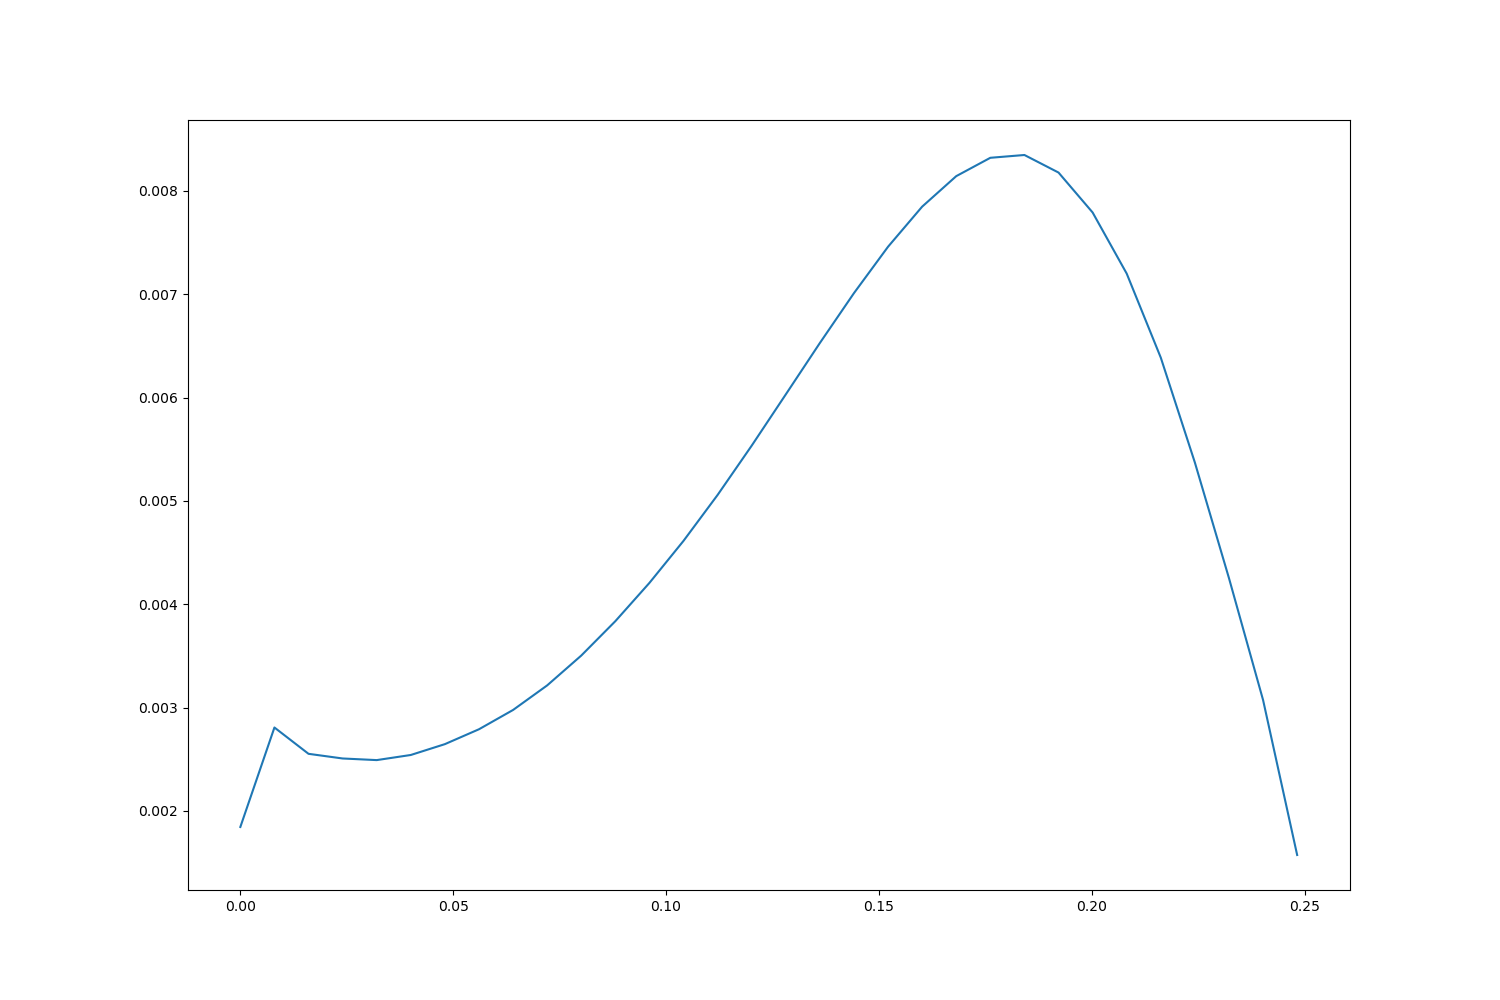

In [69]:
# get the vector of square differences between the Y_sub and Y_pred2
diffs = (Y_sub2 - Y_pred2.detach().numpy())**2

# plot the diffs
plt.figure(figsize=(15, 10))
plt.plot(X_sub2, diffs[:,0], label='diffs_x')

## expanding timeseries while learning

b

In [97]:



# make new model 
history_PINN3 = []

model3 = FFNN(n_layers, n_neurons)



In [98]:
# define the optimizer2 and scheduler2
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', factor=0.7, patience=700, min_lr=1e-6)

In [99]:
num_points = 4
X_temp = X[:4]
Y_temp = Y[:4]
# to torch
X_temp_t = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
Y_temp_t = torch.tensor(Y_temp, dtype=torch.float32)



In [100]:
num_points
epoch = 0

In [101]:
# import datetime
import datetime

In [118]:

while True:

    while True:

        X_temp = X[:num_points]
        Y_temp = Y[:num_points]
        # to torch
        X_temp_t = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
        Y_temp_t = torch.tensor(Y_temp, dtype=torch.float32)




        optimizer3.zero_grad()
        X_temp_t.requires_grad = True
        Y_pred3 = model3(X_temp_t)

        # get the derivatives
        dx_dt_pred3 = torch.autograd.grad(Y_pred3[:,0], X_temp_t, grad_outputs=torch.ones_like(Y_pred3[:,0]), create_graph=True)[0]
        dy_dt_pred3 = torch.autograd.grad(Y_pred3[:,1], X_temp_t, grad_outputs=torch.ones_like(Y_pred3[:,1]), create_graph=True)[0]
        dz_dt_pred3 = torch.autograd.grad(Y_pred3[:,2], X_temp_t, grad_outputs=torch.ones_like(Y_pred3[:,2]), create_graph=True)[0]

        # get true derivatives, using the lorenz parameter
        dx_dt_ode3 = 10 * (Y_pred3[:,1] - Y_pred3[:,0])
        dy_dt_ode3 = Y_pred3[:,0] * (28 - Y_pred3[:,2]) - Y_pred3[:,1]
        dz_dt_ode3 = Y_pred3[:,0] * Y_pred3[:,1] - 8/3 * Y_pred3[:,2]

        # loss ode
        loss_ode3 = loss_fn(dx_dt_pred3[:,0], dx_dt_ode3) + loss_fn(dy_dt_pred3[:,0], dy_dt_ode3) + loss_fn(dz_dt_pred3[:,0], dz_dt_ode3)

        # add loss ic
        loss_ic3 = torch.mean((Y_pred3[0] - Y_temp_t[0])**2)

        loss3 = 20*loss_ode3 + loss_ic3

        loss3.backward()
        optimizer3.step()
        scheduler3.step(loss3)

        epoch = epoch + 1

        

        if epoch % 1000 == 0:
            history_PINN3.append([epoch, loss3.item(), loss_ode3.detach().numpy(), loss_ic3.detach().numpy(), optimizer3.param_groups[0]["lr"], num_points])
            print(f'Epoch {epoch}, Loss {loss3.item()}, lr {optimizer3.param_groups[0]["lr"]}')

        if loss3 < 0.01:
            break

    if num_points % 5 == 0:
        # save model with name as datatime and num_points
        date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        torch.save(model3, f'../models/lorenz_{date}_{num_points}.pt')
        # save history_PINN3
        np.save(f'../models/lorenz_{date}_{num_points}_history.npy', history_PINN3)
        # print saved
        print(f'saved model and history_PINN3 for num_points = {num_points}')

    num_points = num_points + 1
    # print augmented num_points
    print(f'num_points = {num_points}')
    optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.00001)
    scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', factor=0.7, patience=700, min_lr=1e-6)

Epoch 16971000, Loss 0.02220809832215309, lr 1e-05
Epoch 16972000, Loss 0.021602638065814972, lr 1e-05
Epoch 16973000, Loss 0.02327902987599373, lr 1e-05
Epoch 16974000, Loss 0.02198074758052826, lr 1e-05
Epoch 16975000, Loss 0.02088441140949726, lr 1e-05
Epoch 16976000, Loss 0.020859751850366592, lr 1e-05
Epoch 16977000, Loss 0.02043279819190502, lr 1e-05
Epoch 16978000, Loss 0.02053828164935112, lr 1e-05
Epoch 16979000, Loss 0.019998161122202873, lr 1e-05
Epoch 16980000, Loss 0.019787048920989037, lr 1e-05
Epoch 16981000, Loss 0.019577916711568832, lr 1e-05
Epoch 16982000, Loss 0.01938035525381565, lr 1e-05
Epoch 16983000, Loss 0.019177958369255066, lr 1e-05
Epoch 16984000, Loss 0.018982291221618652, lr 1e-05
Epoch 16985000, Loss 0.018790142610669136, lr 1e-05
Epoch 16986000, Loss 0.018640929833054543, lr 1e-05
Epoch 16987000, Loss 0.018436625599861145, lr 1e-05
Epoch 16988000, Loss 0.019009094685316086, lr 1e-05
Epoch 16989000, Loss 0.0181620791554451, lr 1e-05
Epoch 16990000, Loss 

KeyboardInterrupt: 

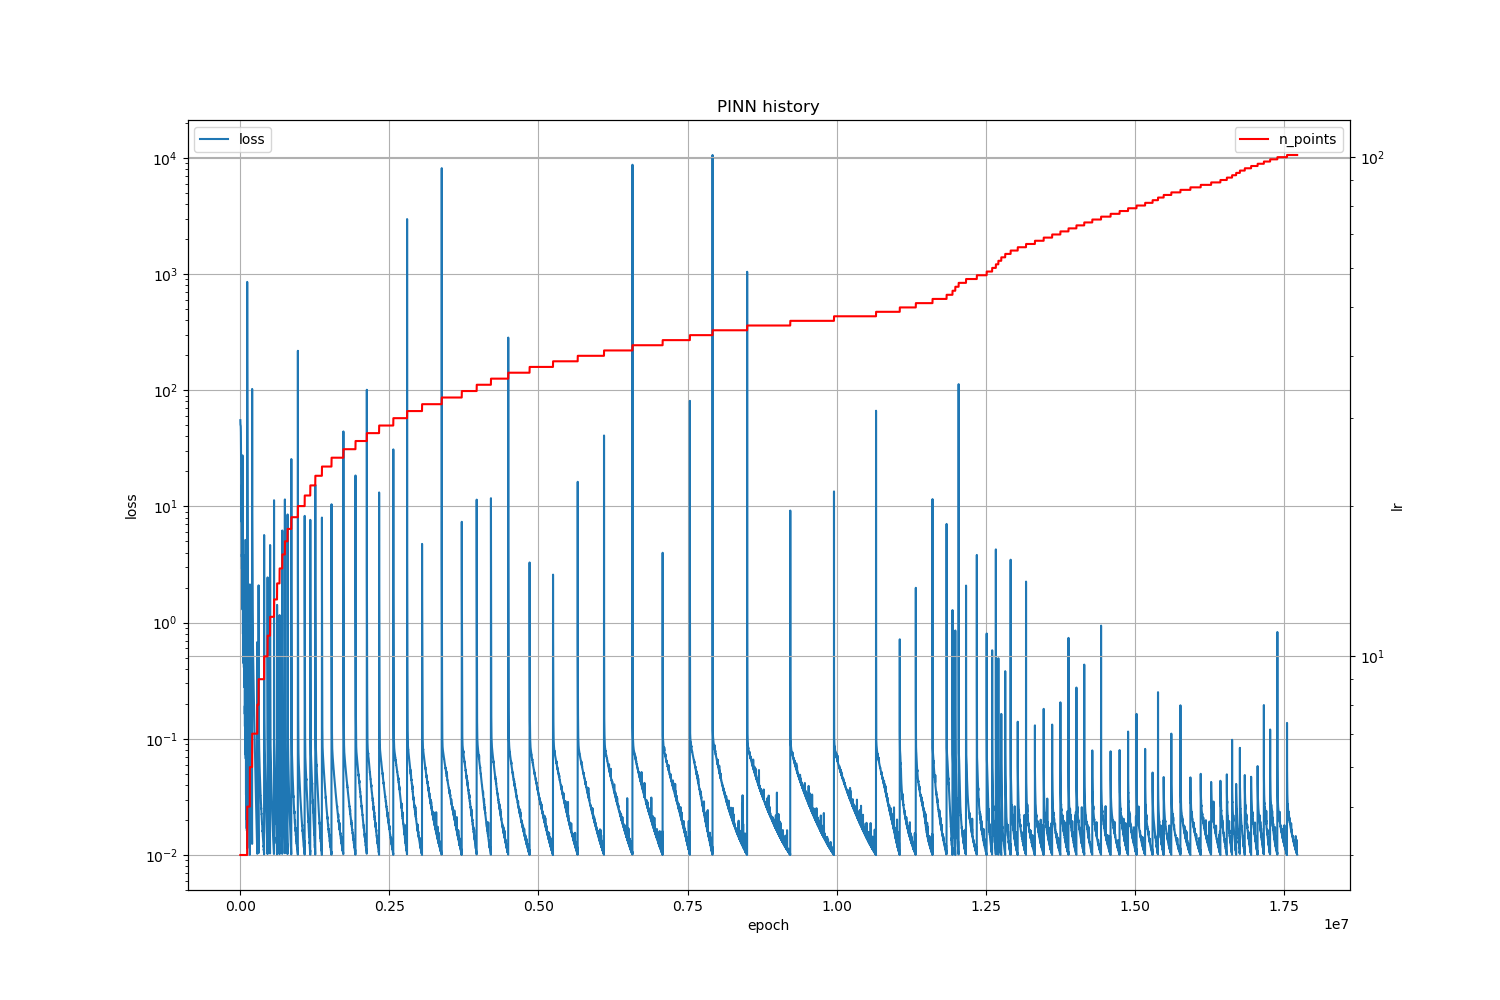

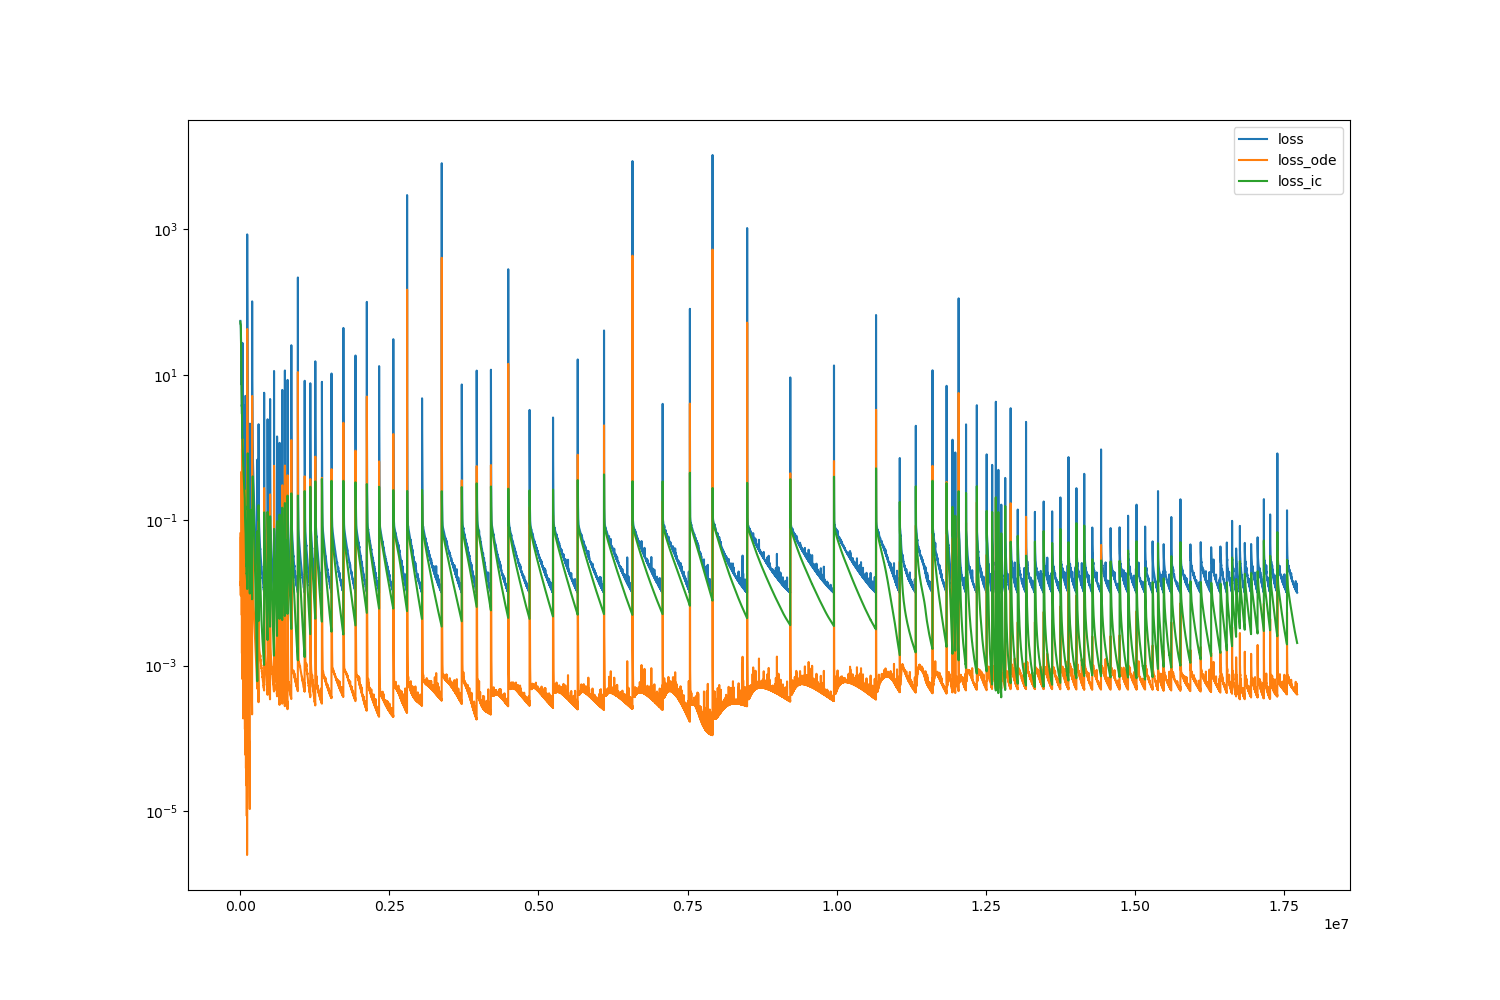

In [119]:
# plot history_PINN3 loss and lr in two subplots
history_PINN3 = np.array(history_PINN3)
fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN3[:, 0],history_PINN3[:, 1], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN3[:, 0], history_PINN3[:, -1], label='n_points', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')

# new plot losses
plt.figure(figsize=(15, 10))
plt.plot(history_PINN3[:, 0], history_PINN3[:, 1], label='loss')
plt.plot(history_PINN3[:, 0], history_PINN3[:, 2], label='loss_ode')
plt.plot(history_PINN3[:, 0], history_PINN3[:, 3], label='loss_ic')
plt.legend()
plt.yscale('log')

# history to list
history_PINN3 = history_PINN3.tolist()

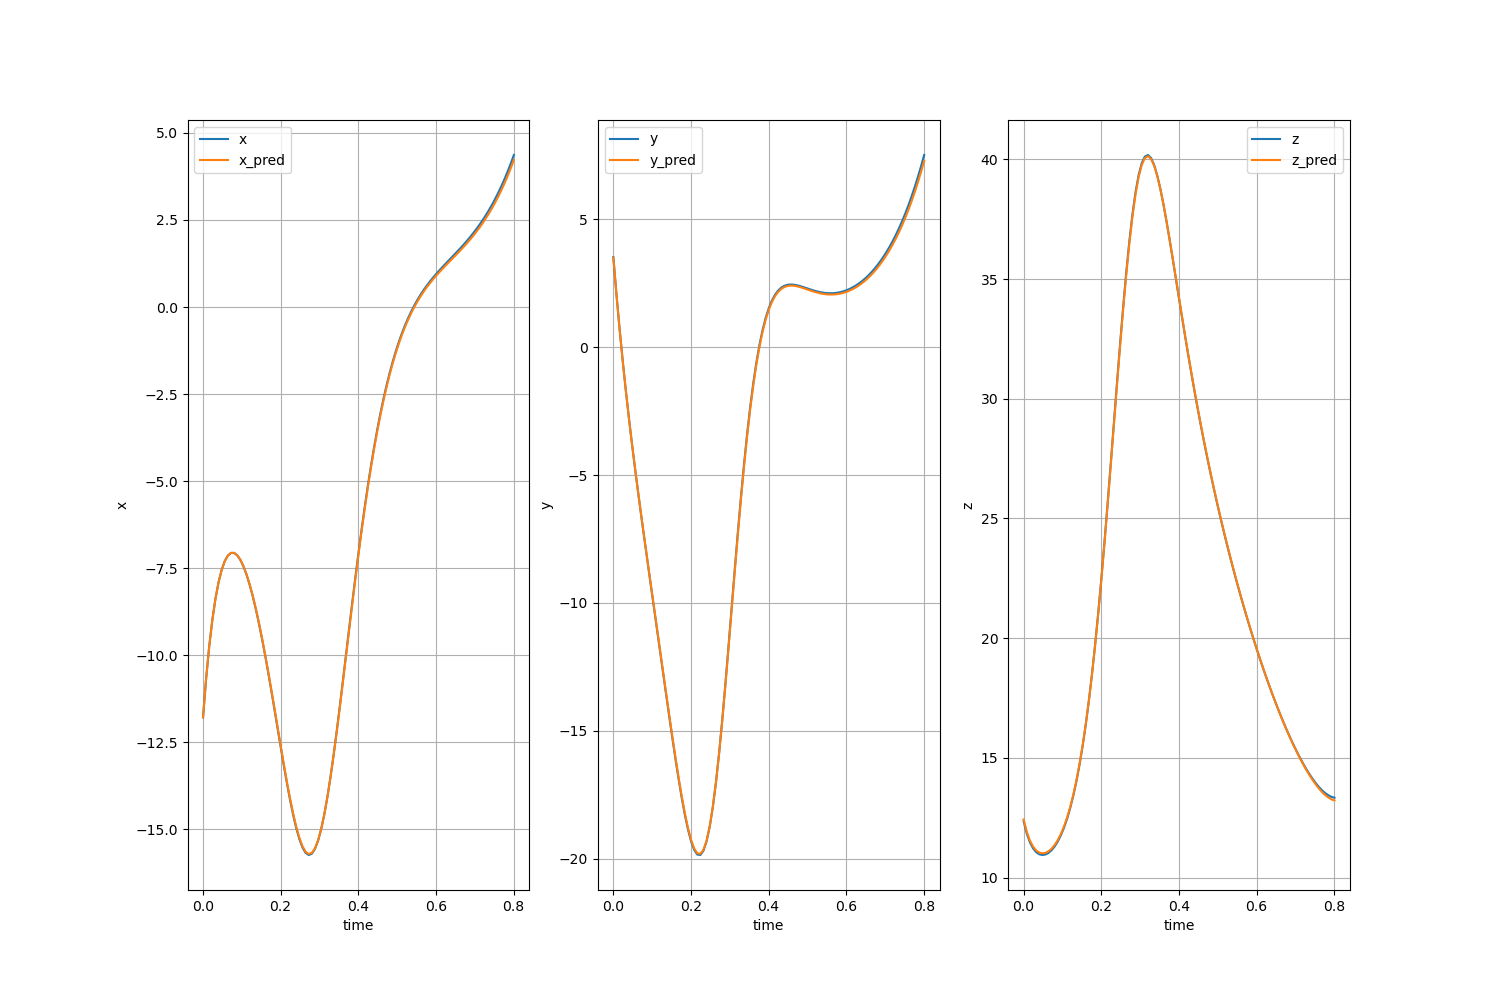

In [120]:
# show prediction
X_temp_t = torch.tensor(X_temp, dtype=torch.float32).view(-1, 1)
Y_temp_t = torch.tensor(Y_temp, dtype=torch.float32)
Y_pred3 = model3(X_temp_t).detach().numpy()
plot_compare_components(X_temp_t, Y_temp_t, Y_pred3)


In [ ]:
model4 = FFNN(n_layers, n_neurons)


In [ ]:
history_PINN4 = []


In [ ]:


# define the optimizer2 and scheduler2
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.01)
scheduler4 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer4, 'min', factor=0.7, patience=700, min_lr=1e-6)


In [ ]:
# define X_sub
X_sub = X[X<0.13]
Y_sub = Y[X<0.13]

In [ ]:
# redo all for model4





# select only time < 2, random points
X_sub4 = 0.12*np.random.rand(10000)
# set the first point to 0
X_sub4[0] = 0
Y_sub4 = np.random.rand(10000, 3)
# set the first point to the lorenz attractor
Y_sub4[0] = Y[0]

# to torch
X_sub_t4 = torch.tensor(X_sub4, dtype=torch.float32).view(-1, 1)
Y_sub_t4 = torch.tensor(Y_sub4, dtype=torch.float32)

for epoch in range(10000):

    optimizer4.zero_grad()
    X_sub_t4.requires_grad = True
    Y_pred4 = model4(X_sub_t4)

    # get the derivatives
    dx_dt_pred4 = torch.autograd.grad(Y_pred4[:,0], X_sub_t4, grad_outputs=torch.ones_like(Y_pred4[:,0]), create_graph=True)[0]
    dy_dt_pred4 = torch.autograd.grad(Y_pred4[:,1], X_sub_t4, grad_outputs=torch.ones_like(Y_pred4[:,1]), create_graph=True)[0]
    dz_dt_pred4 = torch.autograd.grad(Y_pred4[:,2], X_sub_t4, grad_outputs=torch.ones_like(Y_pred4[:,2]), create_graph=True)[0]

    # get true derivatives, using the lorenz parameter
    dx_dt_ode4 = 10 * (Y_pred4[:,1] - Y_pred4[:,0])
    dy_dt_ode4 = Y_pred4[:,0] * (28 - Y_pred4[:,2]) - Y_pred4[:,1]
    dz_dt_ode4 = Y_pred4[:,0] * Y_pred4[:,1] - 8/3 * Y_pred4[:,2]

    # loss ode
    loss_ode4 = loss_fn(dx_dt_pred4[:,0], dx_dt_ode4) + loss_fn(dy_dt_pred4[:,0], dy_dt_ode4) + loss_fn(dz_dt_pred4[:,0], dz_dt_ode4)

    # add loss ic
    loss_ic4 = torch.mean((Y_pred4[0] - Y_sub_t4[0])**2)

    loss4 = 20*loss_ode4 + loss_ic4

    loss4.backward()
    optimizer4.step()
    scheduler4.step(loss4)

    history_PINN4.append([loss4.item(), loss_ode4.detach().numpy(), loss_ic4.detach().numpy(), optimizer4.param_groups[0]["lr"]])

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss4.item()}, lr {optimizer4.param_groups[0]["lr"]}')

Epoch 0, Loss 8.847977638244629, lr 0.01
Epoch 100, Loss 75.8065414428711, lr 0.01
Epoch 200, Loss 65.75528717041016, lr 0.01
Epoch 300, Loss 61.413734436035156, lr 0.01


KeyboardInterrupt: 

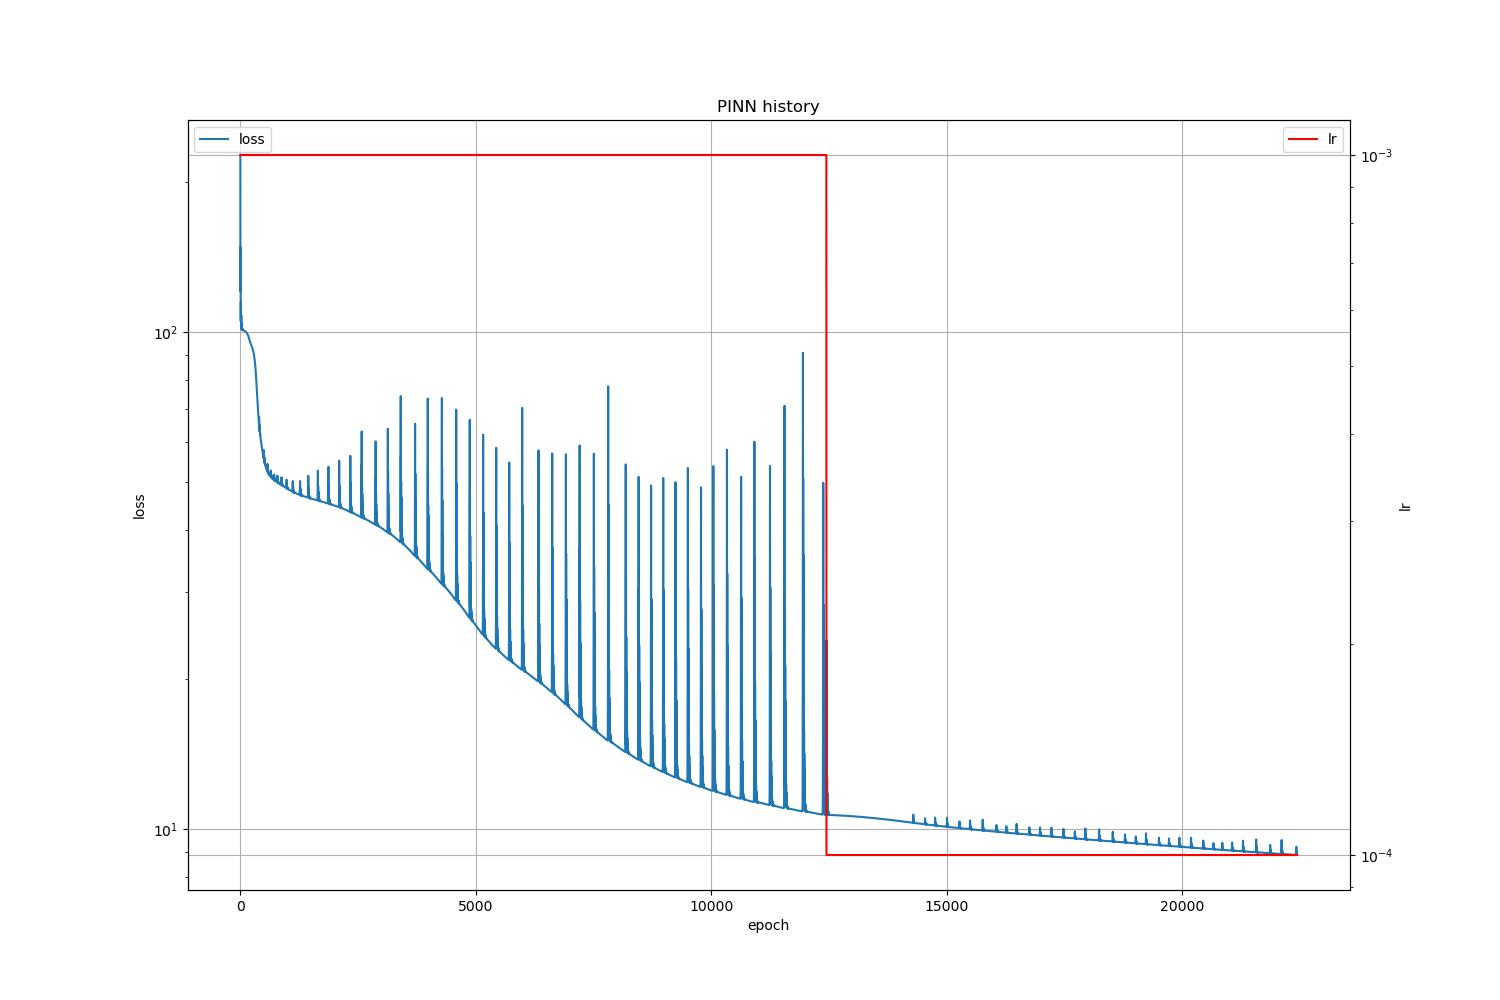

In [ ]:
# show history, suggetst all the code
history_PINN4 = np.array(history_PINN4)
fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history_PINN4[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history_PINN4[:, -1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('PINN history')

# history to list
history_PINN4 = history_PINN4.tolist()

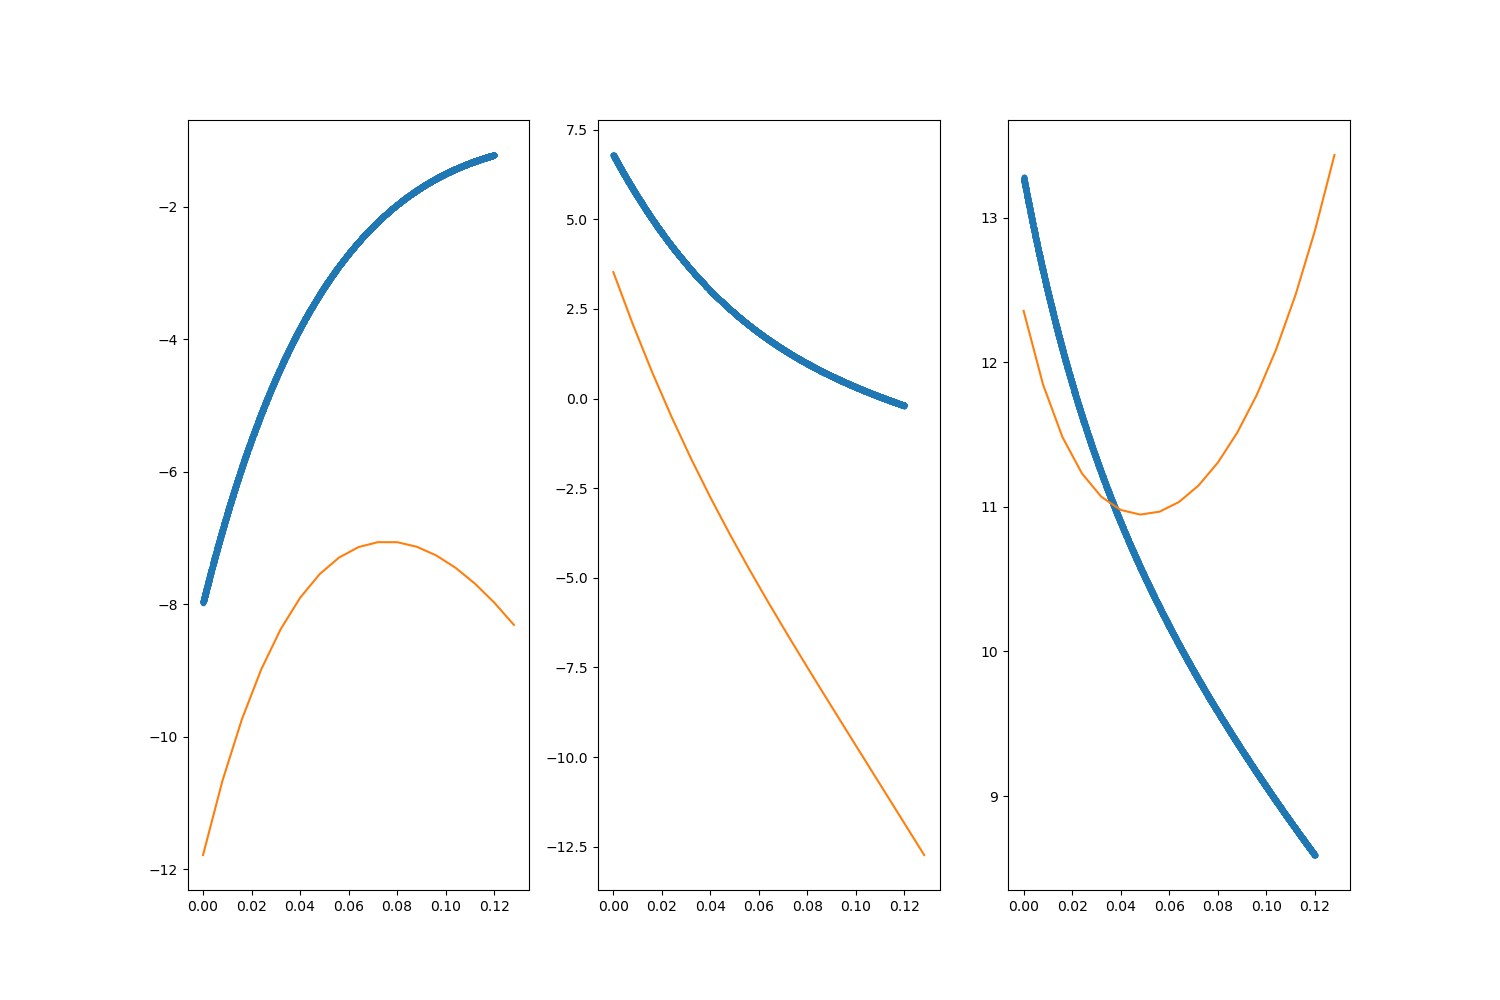

In [ ]:
# for each component plot the prediction and the real data
Y_pred4 = model4(X_sub_t4).detach().numpy()
plt.figure(figsize=(15, 10))
plt.subplot(131)
# no line for the x_pred
plt.plot(X_sub4, Y_pred4[:,0], label='x_pred', linestyle='None', marker='.')
plt.plot(X_sub, Y_sub[:,0], label='x_real')

plt.subplot(132)
plt.plot(X_sub4, Y_pred4[:,1], label='y_pred',linestyle='None', marker='.')
plt.plot(X_sub, Y_sub[:,1], label='y_real')

plt.subplot(133)
plt.plot(X_sub4, Y_pred4[:,2], label='z_pred',linestyle='None', marker='.')
plt.plot(X_sub, Y_sub[:,2], label='z_real')